# **Projetão Disciplina**

### Membros

* Antônio Barros
* André Vasconcelos
* Heitor Santos
* João Vítor Valadares
* Robson Oliveira

## Pré-processamento de dados

In [ ]:
!pip install scikit-plot
!pip install scikeras

  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 4.8.2
    Uninstalling importlib-metadata-4.8.2:
      Successfully uninstalled importlib-metadata-4.8.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
markdown 3.3.6 requires importlib-metadata>=4.4; python_version < "3.10", but you have importlib-metadata 3.10.1 which is incompatible.


In [ ]:
import scikitplot as skplt
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, BaggingClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import roc_auc_score, average_precision_score, plot_confusion_matrix
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from scikeras.wrappers import KerasClassifier
from tensorflow.keras import layers
from scipy import stats
from tensorflow.keras.optimizers import SGD, Adam
from keras.callbacks import EarlyStopping
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from termcolor import colored
import xgboost as xgb


In [ ]:
!wget -q --show-progress --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1fVfxXsB-Ckx6Kk_UpoTJH29sqpcziV_j' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1fVfxXsB-Ckx6Kk_UpoTJH29sqpcziV_j" -O data.csv && rm -rf /tmp/cookies.txt

# https://drive.google.com/file/d/1fVfxXsB-Ckx6Kk_UpoTJH29sqpcziV_j/view?usp=sharing

data.csv            100%[===================>] 738.55M   124MB/s    in 5.7s    


In [ ]:
df = pd.read_csv('data.csv', low_memory=False)
df.drop_duplicates(inplace=True)  # Remove exemplos repetidos
print("Tamanho Dataset : {0}".format(len(df)))



Tamanho Dataset : 389196


In [ ]:
df.head()

,INDEX,UF_1,UF_2,UF_3,UF_4,UF_5,UF_6,UF_7,IDADE,SEXO_1,NIVEL_RELACIONAMENTO_CREDITO01,NIVEL_RELACIONAMENTO_CREDITO02,BANCO_REST_IRPF_ULTIMA_1,BANCO_REST_IRPF_ULTIMA_2,BANCO_REST_IRPF_ULTIMA_3,BANCO_REST_IRPF_ULTIMA_4,BANCO_REST_IRPF_ULTIMA_5,BANCO_REST_IRPF_ULTIMA_6,BANCO_REST_IRPF_ULTIMA_7,ATIVIDADE_EMAIL,EXPOSICAO_ENDERECO,EXPOSICAO_EMAIL,EXPOSICAO_TELEFONE,ATIVIDADE_ENDERECO,ATUALIZACAO_ENDERECO,ATUALIZACAO_EMAIL,EXPOSICAO_CONSUMIDOR_EMAILS,EXPOSICAO_CONSUMIDOR_TELEFONES,ATIVIDADE_TELEFONE,VALOR_PARCELA_BOLSA_FAMILIA,FLAG_BOLSA_FAMILIA_1,SIGLA_PARTIDO_FILIADO_1,SIGLA_PARTIDO_FILIADO_2,SIGLA_PARTIDO_FILIADO_3,SIGLA_PARTIDO_FILIADO_4,SIGLA_PARTIDO_FILIADO_5,SIGLA_PARTIDO_FILIADO_6,SIGLA_PARTIDO_FILIADO_7,FLAG_FILIADO_PARTIDO_POLITICO_1,FLAG_PROUNI_1,...,CEP1_3,CEP1_4,CEP1_5,CEP2_1,CEP2_2,CEP2_3,CEP2_4,CEP2_5,CEP2_6,CEP2_7,CEP2_8,CEP2_9,CEP3_1,CEP3_2,CEP3_3,CEP3_4,CEP3_5,CEP3_6,CEP3_7,CEP3_8,CEP3_9,CEP3_10,CEP3_11,CEP3_12,CEP4_1,CEP4_2,CEP4_3,CEP4_4,CEP4_5,CEP4_6,CEP4_7,CEP4_8,CEP4_9,CEP4_10,CEP4_11,CEP4_12,CEP4_13,CEP4_14,IND_BOM_1_1,IND_BOM_1_2
0,0,1,1,1,0,0,0,0,0.135097920813897,1,0.222222,0.0,0,0,0,0,0,1,1,"5,88E-04",0.041667,0.000000,0.000000,0.1055877023706,0.796392205503436,"-5,14E-03",0.0,0.1,0.131649092377214,0.000000,0,1,1,1,0,0,0,0,0,1,...,1,0,0,1,0,0,1,0,1,0,1,0,0,0,0,1,0,1,1,0,1,0,0,1,0,0,1,0,1,0,0,0,1,1,0,1,1,1,0,1
1,1,1,0,1,0,0,1,0,0.273504064272559,1,0.111111,0.0,0,0,0,0,0,1,1,"5,88E-04",0.013889,0.000000,0.000000,0.147356126735051,0.979967744163738,"-5,14E-03",0.0,0.0,"-2,19E-03",0.000000,0,1,1,1,0,0,0,0,0,0,...,0,1,0,1,1,1,0,0,0,0,1,0,0,1,1,1,0,0,0,1,0,0,1,0,1,1,1,0,1,0,0,1,0,1,1,0,0,0,1,0
2,2,1,0,1,0,0,1,0,0.281909525590524,0,1.000000,0.0,0,0,0,0,0,1,1,"5,88E-04",0.500000,0.000000,0.000000,0.147356126735051,0.398645188152309,"-5,14E-03",0.0,0.0,"-2,19E-03",0.000000,0,1,1,1,0,0,0,0,0,0,...,0,1,0,1,1,1,0,0,0,0,1,0,1,1,0,0,0,0,1,0,1,0,0,1,1,1,0,1,1,0,1,1,0,0,0,0,1,0,1,0
3,3,1,1,1,0,0,0,0,0.225740598269796,0,0.111111,0.0,1,1,0,0,0,0,0,0.478855939782173,0.083333,0.115789,0.055556,0.147356126735051,0.398645188152309,0.0832518801127371,0.2,0.3,0.485948755230412,0.000000,0,1,1,1,0,0,0,0,0,1,...,1,0,0,1,1,0,0,0,0,1,1,0,1,0,0,1,0,1,1,0,0,0,0,1,0,0,1,0,1,0,1,1,0,1,1,0,1,0,1,0
4,4,1,1,0,0,0,1,0,0.480403358741126,0,0.111111,0.0,0,0,0,0,0,1,1,"5,88E-04",0.208333,0.000000,0.111111,0.15160377537405,0.398645188152309,"-5,14E-03",0.0,0.5,0.168943794832414,0.458333,1,1,1,1,0,0,0,0,0,1,...,1,0,1,0,1,1,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,1,1,0,0,0,0,1,1,1,1,0,0,1,0,1,1,0


Apagamos a coluna de index que não agrega ao nosso treinamento

In [ ]:
df.drop('INDEX', axis=1, inplace=True)
df.head()

,UF_1,UF_2,UF_3,UF_4,UF_5,UF_6,UF_7,IDADE,SEXO_1,NIVEL_RELACIONAMENTO_CREDITO01,NIVEL_RELACIONAMENTO_CREDITO02,BANCO_REST_IRPF_ULTIMA_1,BANCO_REST_IRPF_ULTIMA_2,BANCO_REST_IRPF_ULTIMA_3,BANCO_REST_IRPF_ULTIMA_4,BANCO_REST_IRPF_ULTIMA_5,BANCO_REST_IRPF_ULTIMA_6,BANCO_REST_IRPF_ULTIMA_7,ATIVIDADE_EMAIL,EXPOSICAO_ENDERECO,EXPOSICAO_EMAIL,EXPOSICAO_TELEFONE,ATIVIDADE_ENDERECO,ATUALIZACAO_ENDERECO,ATUALIZACAO_EMAIL,EXPOSICAO_CONSUMIDOR_EMAILS,EXPOSICAO_CONSUMIDOR_TELEFONES,ATIVIDADE_TELEFONE,VALOR_PARCELA_BOLSA_FAMILIA,FLAG_BOLSA_FAMILIA_1,SIGLA_PARTIDO_FILIADO_1,SIGLA_PARTIDO_FILIADO_2,SIGLA_PARTIDO_FILIADO_3,SIGLA_PARTIDO_FILIADO_4,SIGLA_PARTIDO_FILIADO_5,SIGLA_PARTIDO_FILIADO_6,SIGLA_PARTIDO_FILIADO_7,FLAG_FILIADO_PARTIDO_POLITICO_1,FLAG_PROUNI_1,RENDA_VIZINHANCA_1,...,CEP1_3,CEP1_4,CEP1_5,CEP2_1,CEP2_2,CEP2_3,CEP2_4,CEP2_5,CEP2_6,CEP2_7,CEP2_8,CEP2_9,CEP3_1,CEP3_2,CEP3_3,CEP3_4,CEP3_5,CEP3_6,CEP3_7,CEP3_8,CEP3_9,CEP3_10,CEP3_11,CEP3_12,CEP4_1,CEP4_2,CEP4_3,CEP4_4,CEP4_5,CEP4_6,CEP4_7,CEP4_8,CEP4_9,CEP4_10,CEP4_11,CEP4_12,CEP4_13,CEP4_14,IND_BOM_1_1,IND_BOM_1_2
0,1,1,1,0,0,0,0,0.135097920813897,1,0.222222,0.0,0,0,0,0,0,1,1,"5,88E-04",0.041667,0.000000,0.000000,0.1055877023706,0.796392205503436,"-5,14E-03",0.0,0.1,0.131649092377214,0.000000,0,1,1,1,0,0,0,0,0,1,0,...,1,0,0,1,0,0,1,0,1,0,1,0,0,0,0,1,0,1,1,0,1,0,0,1,0,0,1,0,1,0,0,0,1,1,0,1,1,1,0,1
1,1,0,1,0,0,1,0,0.273504064272559,1,0.111111,0.0,0,0,0,0,0,1,1,"5,88E-04",0.013889,0.000000,0.000000,0.147356126735051,0.979967744163738,"-5,14E-03",0.0,0.0,"-2,19E-03",0.000000,0,1,1,1,0,0,0,0,0,0,0,...,0,1,0,1,1,1,0,0,0,0,1,0,0,1,1,1,0,0,0,1,0,0,1,0,1,1,1,0,1,0,0,1,0,1,1,0,0,0,1,0
2,1,0,1,0,0,1,0,0.281909525590524,0,1.000000,0.0,0,0,0,0,0,1,1,"5,88E-04",0.500000,0.000000,0.000000,0.147356126735051,0.398645188152309,"-5,14E-03",0.0,0.0,"-2,19E-03",0.000000,0,1,1,1,0,0,0,0,0,0,0,...,0,1,0,1,1,1,0,0,0,0,1,0,1,1,0,0,0,0,1,0,1,0,0,1,1,1,0,1,1,0,1,1,0,0,0,0,1,0,1,0
3,1,1,1,0,0,0,0,0.225740598269796,0,0.111111,0.0,1,1,0,0,0,0,0,0.478855939782173,0.083333,0.115789,0.055556,0.147356126735051,0.398645188152309,0.0832518801127371,0.2,0.3,0.485948755230412,0.000000,0,1,1,1,0,0,0,0,0,1,0,...,1,0,0,1,1,0,0,0,0,1,1,0,1,0,0,1,0,1,1,0,0,0,0,1,0,0,1,0,1,0,1,1,0,1,1,0,1,0,1,0
4,1,1,0,0,0,1,0,0.480403358741126,0,0.111111,0.0,0,0,0,0,0,1,1,"5,88E-04",0.208333,0.000000,0.111111,0.15160377537405,0.398645188152309,"-5,14E-03",0.0,0.5,0.168943794832414,0.458333,1,1,1,1,0,0,0,0,0,1,0,...,1,0,1,0,1,1,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,1,1,0,0,0,0,1,1,1,1,0,0,1,0,1,1,0


Tratando os datos que estão formatados com notação cientifica e foram considerados como string na leitura do CSV.

In [ ]:

def prepareToConvert(x):
  if type(x) == str:
    return x.replace(',', '.')
  return x


df = df.applymap(lambda x: prepareToConvert(x))
df = df.astype(float)

Dividindo o dataset em Classe1 e Classe2 e verificando se existe alguém com as duas classes ou alguém sem classe nenhuma no conjunto de dados

In [ ]:
class1 = df[(df['IND_BOM_1_1']==1)]
class2 = df[(df['IND_BOM_1_2']==1)]
print(f'Quantidade class1 : {len(class1)} \nQuantidade class2 : {len(class2)}')
# repetições ambas as classes
print("Quantidade de classes repetidas: {0}".format(len(df[(df['IND_BOM_1_1'] == 1) & (df['IND_BOM_1_2'] == 1)])))
# nenhuma classe
print("Quantidade de entradas que não correspondem a nenhuma classe: {0}\n".format(len(df[(df['IND_BOM_1_1'] == 0) & (df['IND_BOM_1_2'] == 0)])))

print("Classe 1")
print(class1.head())

print("\nClasse 2")
print(class2.head())

Quantidade class1 : 255098 
Quantidade class2 : 134098
Quantidade de classes repetidas: 0
Quantidade de entradas que não correspondem a nenhuma classe: 0

Classe 1
   UF_1  UF_2  UF_3  UF_4  ...  CEP4_13  CEP4_14  IND_BOM_1_1  IND_BOM_1_2
1   1.0   0.0   1.0   0.0  ...      0.0      0.0          1.0          0.0
2   1.0   0.0   1.0   0.0  ...      1.0      0.0          1.0          0.0
3   1.0   1.0   1.0   0.0  ...      1.0      0.0          1.0          0.0
4   1.0   1.0   0.0   0.0  ...      0.0      1.0          1.0          0.0
5   0.0   1.0   1.0   0.0  ...      0.0      1.0          1.0          0.0

[5 rows x 245 columns]

Classe 2
    UF_1  UF_2  UF_3  UF_4  ...  CEP4_13  CEP4_14  IND_BOM_1_1  IND_BOM_1_2
0    1.0   1.0   1.0   0.0  ...      1.0      1.0          0.0          1.0
10   1.0   0.0   1.0   1.0  ...      0.0      0.0          0.0          1.0
11   1.0   1.0   1.0   0.0  ...      0.0      1.0          0.0          1.0
12   1.0   0.0   1.0   0.0  ...      0.0      0.

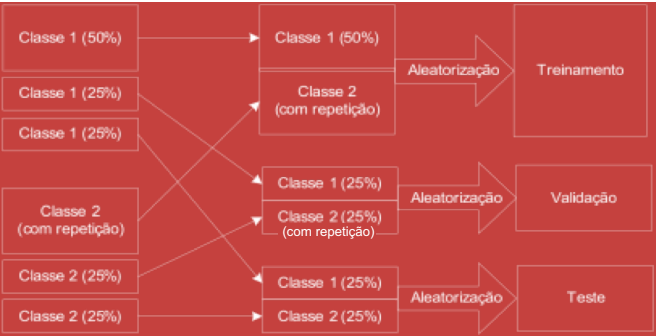Randomizando todas as rows dos dois subsets e dividindo em conjuntos de treino, validação e teste nas proporções de 50%, 25% e 25% respectivamente (numero não divisível por 4) sem repetições até então.


In [ ]:
class1 = class1.sample(frac=1, replace=False, random_state=1)
class2 = class2.sample(frac=1, replace=False, random_state=1)

class1_train = class1[0: int(len(class1)*0.5)]
class1_test = class1[int(len(class1)*0.5): int(len(class1)*0.75)]
class1_valid = class1[int(len(class1)*0.75): len(class1)]
print("Classe 1 - TREINAMENTO TESTE VALIDACAO")
print("Tamanho treinamento: {0}".format(len(class1_train)))
print("Tamanho teste: {0}".format(len(class1_test)))
print("Tamanho validação: {0}".format(len(class1_valid)))

class2_train = class2[0: int(len(class2)*0.5)]
class2_test = class2[int(len(class2)*0.5): int(len(class2)*0.75)]
class2_valid = class2[int(len(class2)*0.75): len(class2)]
print("\nClasse 2 - TREINAMENTO TESTE VALIDACAO")
print("Tamanho treinamento: {0}".format(len(class2_train)))
print("Tamanho teste: {0}".format(len(class2_test)))
print("Tamanho validação: {0}".format(len(class2_valid)))

Classe 1 - TREINAMENTO TESTE VALIDACAO
Tamanho treinamento: 127549
Tamanho teste: 63774
Tamanho validação: 63775

Classe 2 - TREINAMENTO TESTE VALIDACAO
Tamanho treinamento: 67049
Tamanho teste: 33524
Tamanho validação: 33525


Aumentar o conjunto de treino e validação da classe 2 pra ficarem com o mesmo tamanho dos da classe 1 através de repetição.

In [ ]:
z = len(class1_train) / len(class2_train)

class2_train = class2_train.sample(frac=z, replace=True, random_state=1)

print(f'Tamanho Aumentado Class2_Train: {len(class2_train)}')

z = len(class1_valid) / len(class2_valid)
class2_valid = class2_valid.sample(frac=z, replace=True, random_state=1)

print(f'Tamanho Aumentado Class2_valid: {len(class2_valid)}')

Tamanho Aumentado Class2_Train: 127549
Tamanho Aumentado Class2_valid: 63775


Agora iremos unir os conjuntos de treino da classe 1 + classe 2 e randomizar, unir os conjuntos de teste da classe 1 + classe 2 e randomizar e unir os conjuntos de validação da classe 1 + classe 2 e randomizar

In [ ]:
class_train_union = pd.concat([class1_train,class2_train])
class_train_union = class_train_union.sample(frac=1)
print("Tamanho Classe Treinamento: {0}".format(len(class_train_union)))
print(class_train_union.head())

class_valid_union = pd.concat([class1_valid,class2_valid])
class_valid_union = class_valid_union.sample(frac=1)
print("\n Tamanho Classe Validação: {0}".format(len(class_valid_union)))
print(class_valid_union.head())

class_test_valid = pd.concat([class1_test,class2_test]).sample(frac=1, replace=False, random_state=1)
class_test_valid = class_test_valid.sample(frac=1)
print("\n Tamanho Classe Teste: {0}".format(len(class_test_valid)))
print(class_test_valid.head())

Tamanho Classe Treinamento: 255098
        UF_1  UF_2  UF_3  UF_4  ...  CEP4_13  CEP4_14  IND_BOM_1_1  IND_BOM_1_2
23794    1.0   1.0   1.0   0.0  ...      1.0      1.0          0.0          1.0
84628    1.0   1.0   0.0   0.0  ...      0.0      0.0          1.0          0.0
39199    1.0   1.0   1.0   0.0  ...      1.0      0.0          0.0          1.0
269734   1.0   1.0   1.0   0.0  ...      0.0      1.0          0.0          1.0
102075   0.0   1.0   1.0   1.0  ...      0.0      1.0          0.0          1.0

[5 rows x 245 columns]

 Tamanho Classe Validação: 127550
        UF_1  UF_2  UF_3  UF_4  ...  CEP4_13  CEP4_14  IND_BOM_1_1  IND_BOM_1_2
363960   1.0   1.0   0.0   0.0  ...      0.0      0.0          1.0          0.0
227176   1.0   1.0   1.0   0.0  ...      0.0      0.0          0.0          1.0
367158   1.0   1.0   0.0   0.0  ...      0.0      1.0          0.0          1.0
49253    1.0   0.0   0.0   1.0  ...      0.0      0.0          0.0          1.0
272300   1.0   1.0   0.0  

In [ ]:
train_array = class_train_union.to_numpy()
valid_array = class_valid_union.to_numpy()
test_array = class_test_valid.to_numpy()
x_train = train_array[:,:243]
y_train = train_array[:,243:]
x_valid = valid_array[:,:243]
y_valid = valid_array[:,243:]
x_test = test_array[:,:243]
y_test = test_array[:,243:]

x_test.shape

(97298, 243)

Funções auxiliares dadas

In [ ]:
def extract_final_losses(history):
    """Função para extrair o melhor loss de treino e validação.
    
    Argumento(s):
    history -- Objeto retornado pela função fit do keras.
    
    Retorno:
    Dicionário contendo o melhor loss de treino e de validação baseado 
    no menor loss de validação.
    """
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    idx_min_val_loss = np.argmin(val_loss)
    return {'train_loss': train_loss[idx_min_val_loss], 'val_loss': val_loss[idx_min_val_loss]}

def plot_training_error_curves(history):
    """Função para plotar as curvas de erro do treinamento da rede neural.
    
    Argumento(s):
    history -- Objeto retornado pela função fit do keras.
    
    Retorno:
    A função gera o gráfico do treino da rede e retorna None.
    """
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    fig, ax = plt.subplots()
    ax.plot(train_loss, label='Train')
    ax.plot(val_loss, label='Validation')
    ax.set(title='Training and Validation Error Curves', xlabel='Epochs', ylabel='Loss (MSE)')
    ax.legend()
    plt.show()

def compute_performance_metrics(y, y_pred_class, y_pred_scores=None):
    accuracy = accuracy_score(y, y_pred_class)
    recall = recall_score(y, y_pred_class)
    precision = precision_score(y, y_pred_class)
    f1 = f1_score(y, y_pred_class)
    performance_metrics = (accuracy, recall, precision, f1)
    if y_pred_scores is not None:
        skplt.metrics.plot_ks_statistic(y, y_pred_scores)
        plt.show()
        y_pred_scores = y_pred_scores[:, 1]
        auroc = roc_auc_score(y, y_pred_scores)
        aupr = average_precision_score(y, y_pred_scores)
        performance_metrics = performance_metrics + (auroc, aupr)
    return performance_metrics

def print_metrics_summary(accuracy, recall, precision, f1, auroc=None, aupr=None):
    print()
    print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy))
    print("{metric:<18}{value:.4f}".format(metric="Recall:", value=recall))
    print("{metric:<18}{value:.4f}".format(metric="Precision:", value=precision))
    print("{metric:<18}{value:.4f}".format(metric="F1:", value=f1))
    if auroc is not None:
        print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=auroc))
    if aupr is not None:
        print("{metric:<18}{value:.4f}".format(metric="AUPR:", value=aupr))

## MLP Primeira Versão

Iniciamos nossa primeira versão da Rede MLP, com parâmetros básicos da rede. Colocamos a quantidade épocas alta, pois o nosso critério de parada vai ser pelo Early Stopping

In [ ]:
epochs = 10000
batch_size = 80
patience = 20

In [ ]:
classifier1 = keras.Sequential([
    keras.Input(x_train.shape[1]),
    layers.Flatten(),
    layers.Dense(45, activation="tanh"),
    layers.Dense(1, activation="sigmoid")
])

classifier1.compile(loss="mean_squared_error", optimizer=Adam(), metrics=["accuracy"])

classifier1.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_7 (Flatten)         (None, 243)               0         
                                                                 
 dense_16 (Dense)            (None, 45)                10980     
                                                                 
 dense_17 (Dense)            (None, 1)                 46        
                                                                 
Total params: 11,026
Trainable params: 11,026
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history1 = classifier1.fit(tf.convert_to_tensor(x_train,np.float64),tf.convert_to_tensor(y_train[:,0],np.float64), batch_size=batch_size, epochs=epochs, 
                         callbacks=[EarlyStopping(patience=20)], validation_data=(tf.convert_to_tensor(x_valid,np.float64), tf.convert_to_tensor(y_valid[:,0],np.float64)))

Epoch 1/10000
3189/3189 [==============================] - 8s 3ms/step - loss: 0.2359 - accuracy: 0.6044 - val_loss: 0.2311 - val_accuracy: 0.6136
Epoch 2/10000
3189/3189 [==============================] - 8s 2ms/step - loss: 0.2309 - accuracy: 0.6134 - val_loss: 0.2294 - val_accuracy: 0.6169
Epoch 3/10000
3189/3189 [==============================] - 7s 2ms/step - loss: 0.2293 - accuracy: 0.6186 - val_loss: 0.2291 - val_accuracy: 0.6200
Epoch 4/10000
3189/3189 [==============================] - 7s 2ms/step - loss: 0.2276 - accuracy: 0.6233 - val_loss: 0.2280 - val_accuracy: 0.6207
Epoch 5/10000
3189/3189 [==============================] - 8s 2ms/step - loss: 0.2268 - accuracy: 0.6246 - val_loss: 0.2276 - val_accuracy: 0.6221
Epoch 6/10000
3189/3189 [==============================] - 7s 2ms/step - loss: 0.2262 - accuracy: 0.6264 - val_loss: 0.2283 - val_accuracy: 0.6200
Epoch 7/10000
3189/3189 [==============================] - 7s 2ms/step - loss: 0.2255 - accuracy: 0.6272 - val_loss: 0

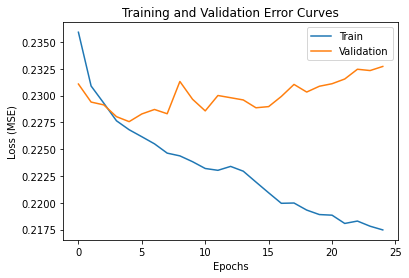

In [ ]:
plot_training_error_curves(history1)

In [ ]:
mlp_y_pred_class = (classifier1.predict(x_test) > 0.5).astype("int32")
mlp_y_pred_scores = classifier1.predict(x_test)
mlp_y_pred_scores_0 = 1 - mlp_y_pred_scores
mlp_y_pred_scores = np.concatenate([mlp_y_pred_scores_0, mlp_y_pred_scores], axis=1)

Matriz de confusão no conjunto de teste:


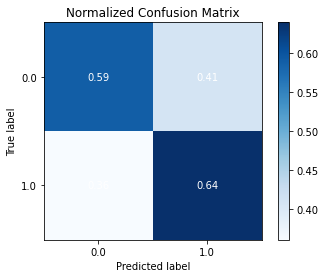

In [ ]:
print('Matriz de confusão no conjunto de teste:')

skplt.metrics.plot_confusion_matrix(y_test[:,0], mlp_y_pred_class, normalize=True)
plt.show()

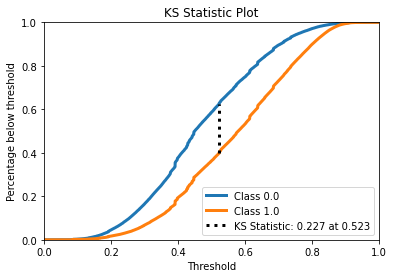


Accuracy:         0.6196
Recall:           0.6371
Precision:        0.7456
F1:               0.6871
AUROC:            0.6582
AUPR:             0.7760


In [ ]:
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_test[:,0], mlp_y_pred_class, mlp_y_pred_scores)
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

## MLP Segunda Versão 

Na segunda versão mudamos a função de otimização para SGD

In [ ]:
classifier2 = keras.Sequential([
    keras.Input(x_train.shape[1]),
    layers.Flatten(),
    layers.Dense(45, activation="tanh"),
    layers.Dense(1, activation="sigmoid")
])

classifier2.compile(loss="mean_squared_error", optimizer=SGD(), metrics=["accuracy"])

classifier2.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_9 (Flatten)         (None, 243)               0         
                                                                 
 dense_20 (Dense)            (None, 45)                10980     
                                                                 
 dense_21 (Dense)            (None, 1)                 46        
                                                                 
Total params: 11,026
Trainable params: 11,026
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history2 = classifier2.fit(tf.convert_to_tensor(x_train,np.float64),tf.convert_to_tensor(y_train[:,0],np.float64), batch_size=batch_size, epochs=epochs, 
                         callbacks=[EarlyStopping(patience=20)], validation_data=(tf.convert_to_tensor(x_valid,np.float64), tf.convert_to_tensor(y_valid[:,0],np.float64)))

Epoch 1/10000
3189/3189 [==============================] - 8s 2ms/step - loss: 0.2499 - accuracy: 0.5652 - val_loss: 0.2414 - val_accuracy: 0.5907
Epoch 2/10000
3189/3189 [==============================] - 7s 2ms/step - loss: 0.2391 - accuracy: 0.5957 - val_loss: 0.2366 - val_accuracy: 0.6020
Epoch 3/10000
3189/3189 [==============================] - 6s 2ms/step - loss: 0.2359 - accuracy: 0.6029 - val_loss: 0.2343 - val_accuracy: 0.6077
Epoch 4/10000
3189/3189 [==============================] - 8s 2ms/step - loss: 0.2343 - accuracy: 0.6069 - val_loss: 0.2332 - val_accuracy: 0.6095
Epoch 5/10000
3189/3189 [==============================] - 7s 2ms/step - loss: 0.2336 - accuracy: 0.6089 - val_loss: 0.2328 - val_accuracy: 0.6110
Epoch 6/10000
3189/3189 [==============================] - 7s 2ms/step - loss: 0.2331 - accuracy: 0.6100 - val_loss: 0.2323 - val_accuracy: 0.6115
Epoch 7/10000
3189/3189 [==============================] - 6s 2ms/step - loss: 0.2327 - accuracy: 0.6100 - val_loss: 0

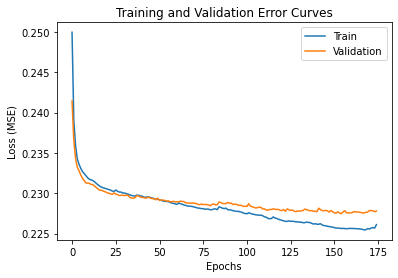

In [ ]:
plot_training_error_curves(history2)

In [ ]:
mlp_y_pred_class_2 = (classifier2.predict(x_test) > 0.5).astype("int32")
mlp_y_pred_scores_2 = classifier2.predict(x_test)
mlp_y_pred_scores_0_2 = 1 - mlp_y_pred_scores_2
mlp_y_pred_scores_2 = np.concatenate([mlp_y_pred_scores_0_2, mlp_y_pred_scores_2], axis=1)

Matriz de confusão no conjunto de teste:


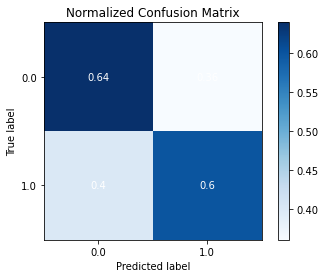

In [ ]:
print('Matriz de confusão no conjunto de teste:')

skplt.metrics.plot_confusion_matrix(y_test[:,0], mlp_y_pred_class_2, normalize=True)
plt.show()

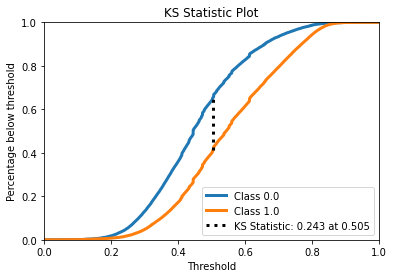


Accuracy:         0.6150
Recall:           0.6024
Precision:        0.7605
F1:               0.6723
AUROC:            0.6684
AUPR:             0.7838


In [ ]:
accuracy2, recall2, precision2, f12, auroc2, aupr2 = compute_performance_metrics(y_test[:,0], mlp_y_pred_class_2, mlp_y_pred_scores_2)
print_metrics_summary(accuracy2, recall2, precision2, f12, auroc2, aupr2)

## MLP Terceira Versão 

Na terceira versão, temos mudar a função de ativação para relu.

In [ ]:
classifier3 = keras.Sequential([
    keras.Input(x_train.shape[1]),
    layers.Flatten(),
    layers.Dense(45, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

classifier3.compile(loss="mean_squared_error", optimizer=SGD(), metrics=["accuracy"])

classifier3.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_8 (Flatten)         (None, 243)               0         
                                                                 
 dense_18 (Dense)            (None, 45)                10980     
                                                                 
 dense_19 (Dense)            (None, 1)                 46        
                                                                 
Total params: 11,026
Trainable params: 11,026
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history3 = classifier3.fit(tf.convert_to_tensor(x_train,np.float64),tf.convert_to_tensor(y_train[:,0],np.float64), batch_size=batch_size, epochs=epochs, 
                         callbacks=[EarlyStopping(patience=20)], validation_data=(tf.convert_to_tensor(x_valid,np.float64), tf.convert_to_tensor(y_valid[:,0],np.float64)))

Epoch 1/10000
3189/3189 [==============================] - 8s 2ms/step - loss: 0.2827 - accuracy: 0.5564 - val_loss: 0.2773 - val_accuracy: 0.5840
Epoch 2/10000
3189/3189 [==============================] - 7s 2ms/step - loss: 0.2745 - accuracy: 0.5911 - val_loss: 0.2741 - val_accuracy: 0.5950
Epoch 3/10000
3189/3189 [==============================] - 6s 2ms/step - loss: 0.2731 - accuracy: 0.5981 - val_loss: 0.2736 - val_accuracy: 0.5989
Epoch 4/10000
3189/3189 [==============================] - 7s 2ms/step - loss: 0.2723 - accuracy: 0.6004 - val_loss: 0.2712 - val_accuracy: 0.6025
Epoch 5/10000
3189/3189 [==============================] - 7s 2ms/step - loss: 0.2710 - accuracy: 0.6030 - val_loss: 0.2710 - val_accuracy: 0.6039
Epoch 6/10000
3189/3189 [==============================] - 7s 2ms/step - loss: 0.2709 - accuracy: 0.6038 - val_loss: 0.2705 - val_accuracy: 0.6049
Epoch 7/10000
3189/3189 [==============================] - 7s 2ms/step - loss: 0.2704 - accuracy: 0.6048 - val_loss: 0

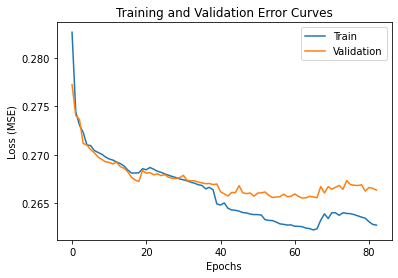

In [ ]:
plot_training_error_curves(history3)

In [ ]:
mlp_y_pred_class_3 = (classifier3.predict(x_test) > 0.5).astype("int32")
mlp_y_pred_scores_3 = classifier3.predict(x_test)
mlp_y_pred_scores_0_3 = 1 - mlp_y_pred_scores_3
mlp_y_pred_scores_3 = np.concatenate([mlp_y_pred_scores_0_3, mlp_y_pred_scores_3], axis=1)

Matriz de confusão no conjunto de teste:


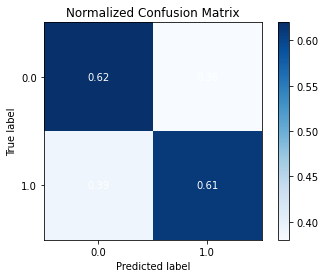

In [ ]:
print('Matriz de confusão no conjunto de teste:')

skplt.metrics.plot_confusion_matrix(y_test[:,0], mlp_y_pred_class_3, normalize=True)
plt.show()

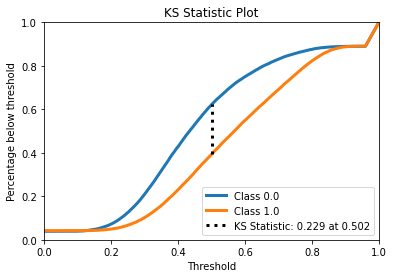


Accuracy:         0.6121
Recall:           0.6074
Precision:        0.7531
F1:               0.6724
AUROC:            0.6334
AUPR:             0.7266


In [ ]:
accuracy3, recall3, precision3, f13, auroc3, aupr3 = compute_performance_metrics(y_test[:,0], mlp_y_pred_class_3, mlp_y_pred_scores_3)
print_metrics_summary(accuracy3, recall3, precision3, f13, auroc3, aupr3)

## MLP Quarta Versão 

Na terceira versão, mudamos a função de ativação para sigmoide

In [ ]:
classifier4 = keras.Sequential([
    keras.Input(x_train.shape[1]),
    layers.Flatten(),
    layers.Dense(45, activation="sigmoid"),
    layers.Dense(1, activation="sigmoid")
])

classifier4.compile(loss="mean_squared_error", optimizer=SGD(), metrics=["accuracy"])

classifier4.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_10 (Flatten)        (None, 243)               0         
                                                                 
 dense_22 (Dense)            (None, 45)                10980     
                                                                 
 dense_23 (Dense)            (None, 1)                 46        
                                                                 
Total params: 11,026
Trainable params: 11,026
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history4 = classifier4.fit(tf.convert_to_tensor(x_train,np.float64),tf.convert_to_tensor(y_train[:,0],np.float64), batch_size=batch_size, epochs=epochs, 
                         callbacks=[EarlyStopping(patience=20)], validation_data=(tf.convert_to_tensor(x_valid,np.float64), tf.convert_to_tensor(y_valid[:,0],np.float64)))

Epoch 1/10000
3189/3189 [==============================] - 8s 2ms/step - loss: 0.2498 - accuracy: 0.5383 - val_loss: 0.2468 - val_accuracy: 0.5624
Epoch 2/10000
3189/3189 [==============================] - 6s 2ms/step - loss: 0.2458 - accuracy: 0.5693 - val_loss: 0.2443 - val_accuracy: 0.5757
Epoch 3/10000
3189/3189 [==============================] - 12s 4ms/step - loss: 0.2436 - accuracy: 0.5785 - val_loss: 0.2423 - val_accuracy: 0.5841
Epoch 4/10000
3189/3189 [==============================] - 8s 2ms/step - loss: 0.2418 - accuracy: 0.5841 - val_loss: 0.2408 - val_accuracy: 0.5874
Epoch 5/10000
3189/3189 [==============================] - 9s 3ms/step - loss: 0.2404 - accuracy: 0.5870 - val_loss: 0.2394 - val_accuracy: 0.5913
Epoch 6/10000
3189/3189 [==============================] - 9s 3ms/step - loss: 0.2391 - accuracy: 0.5917 - val_loss: 0.2382 - val_accuracy: 0.5948
Epoch 7/10000
3189/3189 [==============================] - 6s 2ms/step - loss: 0.2381 - accuracy: 0.5953 - val_loss: 

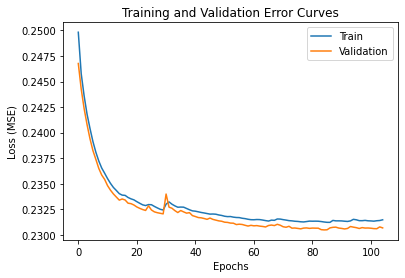

In [ ]:
plot_training_error_curves(history4)

In [ ]:
mlp_y_pred_class_4 = (classifier4.predict(x_test) > 0.5).astype("int32")
mlp_y_pred_scores_4 = classifier4.predict(x_test)
mlp_y_pred_scores_0_4 = 1 - mlp_y_pred_scores_4
mlp_y_pred_scores_4 = np.concatenate([mlp_y_pred_scores_0_4, mlp_y_pred_scores_4], axis=1)

Matriz de confusão no conjunto de teste:


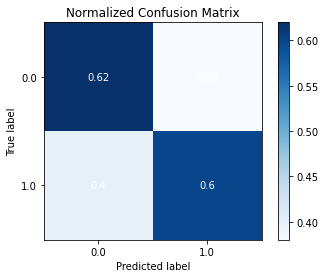

In [ ]:
print('Matriz de confusão no conjunto de teste:')

skplt.metrics.plot_confusion_matrix(y_test[:,0], mlp_y_pred_class_4, normalize=True)
plt.show()

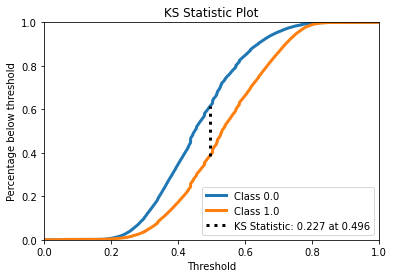


Accuracy:         0.6104
Recall:           0.6045
Precision:        0.7525
F1:               0.6704
AUROC:            0.6570
AUPR:             0.7728


In [ ]:
accuracy4, recall4, precision4, f14, auroc4, aupr4 = compute_performance_metrics(y_test[:,0], mlp_y_pred_class_4, mlp_y_pred_scores_4)
print_metrics_summary(accuracy4, recall4, precision4, f14, auroc4, aupr4)

## MLP Quinta Versão 

Na quinta versão, mudamos a quantidade de neurônios na camada, mantivermos a função de ativação de tanh por apresentar melhores resultados em relação ao KS.

In [ ]:
classifier5 = keras.Sequential([
    keras.Input(x_train.shape[1]),
    layers.Flatten(),
    layers.Dense(64, activation="tanh"),
    layers.Dense(1, activation="sigmoid")
])

classifier5.compile(loss="mean_squared_error", optimizer=SGD(), metrics=["accuracy"])

classifier5.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_11 (Flatten)        (None, 243)               0         
                                                                 
 dense_24 (Dense)            (None, 64)                15616     
                                                                 
 dense_25 (Dense)            (None, 1)                 65        
                                                                 
Total params: 15,681
Trainable params: 15,681
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history5 = classifier5.fit(tf.convert_to_tensor(x_train,np.float64),tf.convert_to_tensor(y_train[:,0],np.float64), batch_size=batch_size, epochs=epochs, 
                         callbacks=[EarlyStopping(patience=20)], validation_data=(tf.convert_to_tensor(x_valid,np.float64), tf.convert_to_tensor(y_valid[:,0],np.float64)))

Epoch 1/10000
3189/3189 [==============================] - 7s 2ms/step - loss: 0.2481 - accuracy: 0.5648 - val_loss: 0.2397 - val_accuracy: 0.5942
Epoch 2/10000
3189/3189 [==============================] - 7s 2ms/step - loss: 0.2380 - accuracy: 0.5977 - val_loss: 0.2365 - val_accuracy: 0.6029
Epoch 3/10000
3189/3189 [==============================] - 7s 2ms/step - loss: 0.2358 - accuracy: 0.6042 - val_loss: 0.2348 - val_accuracy: 0.6072
Epoch 4/10000
3189/3189 [==============================] - 7s 2ms/step - loss: 0.2347 - accuracy: 0.6073 - val_loss: 0.2338 - val_accuracy: 0.6106
Epoch 5/10000
3189/3189 [==============================] - 7s 2ms/step - loss: 0.2338 - accuracy: 0.6093 - val_loss: 0.2330 - val_accuracy: 0.6114
Epoch 6/10000
3189/3189 [==============================] - 7s 2ms/step - loss: 0.2331 - accuracy: 0.6102 - val_loss: 0.2323 - val_accuracy: 0.6139
Epoch 7/10000
3189/3189 [==============================] - 6s 2ms/step - loss: 0.2325 - accuracy: 0.6118 - val_loss: 0

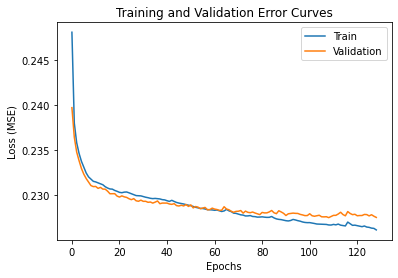

In [ ]:
plot_training_error_curves(history5)

In [ ]:
mlp_y_pred_class_5 = (classifier5.predict(x_test) > 0.5).astype("int32")
mlp_y_pred_scores_5 = classifier5.predict(x_test)
mlp_y_pred_scores_0_5 = 1 - mlp_y_pred_scores_5
mlp_y_pred_scores_5 = np.concatenate([mlp_y_pred_scores_0_5, mlp_y_pred_scores_5], axis=1)

Matriz de confusão no conjunto de teste:


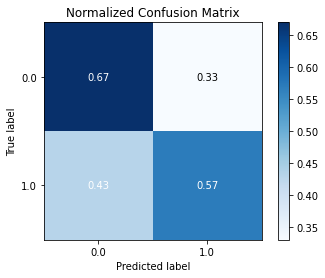

In [ ]:
print('Matriz de confusão no conjunto de teste:')

skplt.metrics.plot_confusion_matrix(y_test[:,0], mlp_y_pred_class_5, normalize=True)
plt.show()

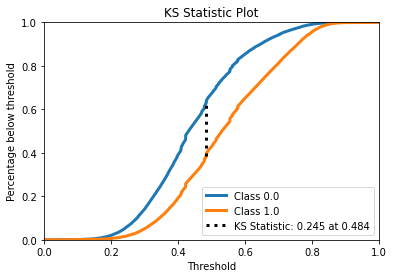


Accuracy:         0.6065
Recall:           0.5723
Precision:        0.7683
F1:               0.6560
AUROC:            0.6700
AUPR:             0.7860


In [ ]:
accuracy5, recall5, precision5, f15, auroc5, aupr5 = compute_performance_metrics(y_test[:,0], mlp_y_pred_class_5, mlp_y_pred_scores_5)
print_metrics_summary(accuracy5, recall5, precision5, f15, auroc5, aupr5)

## MLP Sexta Versão 

Na sexta versão, aumentamos o numero de camadas

In [ ]:
classifier6 = keras.Sequential([
    keras.Input(x_train.shape[1]),
    layers.Flatten(),
    layers.Dense(64, activation="tanh"),
    layers.Dense(122, activation="sigmoid"),
    layers.Dense(1, activation="sigmoid")
])

classifier6.compile(loss="mean_squared_error", optimizer=SGD(), metrics=["accuracy"])

classifier6.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_12 (Flatten)        (None, 243)               0         
                                                                 
 dense_26 (Dense)            (None, 64)                15616     
                                                                 
 dense_27 (Dense)            (None, 122)               7930      
                                                                 
 dense_28 (Dense)            (None, 1)                 123       
                                                                 
Total params: 23,669
Trainable params: 23,669
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history6 = classifier6.fit(tf.convert_to_tensor(x_train,np.float64),tf.convert_to_tensor(y_train[:,0],np.float64), batch_size=batch_size, epochs=epochs, 
                         callbacks=[EarlyStopping(patience=20)], validation_data=(tf.convert_to_tensor(x_valid,np.float64), tf.convert_to_tensor(y_valid[:,0],np.float64)))

Epoch 1/10000
3189/3189 [==============================] - 9s 3ms/step - loss: 0.2495 - accuracy: 0.5278 - val_loss: 0.2470 - val_accuracy: 0.5566
Epoch 2/10000
3189/3189 [==============================] - 8s 2ms/step - loss: 0.2459 - accuracy: 0.5624 - val_loss: 0.2440 - val_accuracy: 0.5731
Epoch 3/10000
3189/3189 [==============================] - 8s 3ms/step - loss: 0.2430 - accuracy: 0.5769 - val_loss: 0.2409 - val_accuracy: 0.5878
Epoch 4/10000
3189/3189 [==============================] - 7s 2ms/step - loss: 0.2401 - accuracy: 0.5882 - val_loss: 0.2382 - val_accuracy: 0.5958
Epoch 5/10000
3189/3189 [==============================] - 7s 2ms/step - loss: 0.2378 - accuracy: 0.5960 - val_loss: 0.2362 - val_accuracy: 0.6000
Epoch 6/10000
3189/3189 [==============================] - 7s 2ms/step - loss: 0.2362 - accuracy: 0.5999 - val_loss: 0.2347 - val_accuracy: 0.6027
Epoch 7/10000
3189/3189 [==============================] - 8s 3ms/step - loss: 0.2352 - accuracy: 0.6014 - val_loss: 0

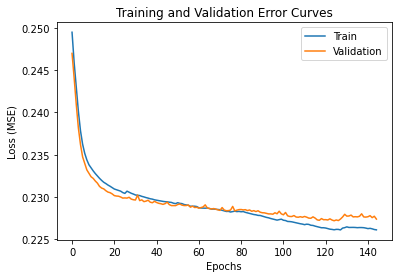

In [ ]:
plot_training_error_curves(history6)

In [ ]:
mlp_y_pred_class_6 = (classifier6.predict(x_test) > 0.5).astype("int32")
mlp_y_pred_scores_6 = classifier6.predict(x_test)
mlp_y_pred_scores_0_6 = 1 - mlp_y_pred_scores_6
mlp_y_pred_scores_6 = np.concatenate([mlp_y_pred_scores_0_6, mlp_y_pred_scores_6], axis=1)

Matriz de confusão no conjunto de teste:


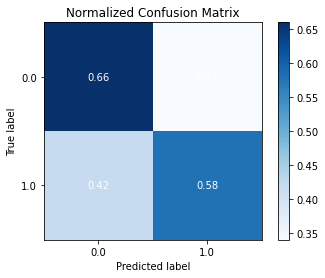

In [ ]:
print('Matriz de confusão no conjunto de teste:')

skplt.metrics.plot_confusion_matrix(y_test[:,0], mlp_y_pred_class_6, normalize=True)
plt.show()

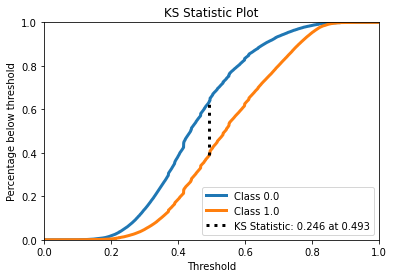


Accuracy:         0.6097
Recall:           0.5837
Precision:        0.7651
F1:               0.6622
AUROC:            0.6695
AUPR:             0.7805


In [ ]:
accuracy6, recall6, precision6, f16, auroc6, aupr6 = compute_performance_metrics(y_test[:,0], mlp_y_pred_class_6, mlp_y_pred_scores_6)
print_metrics_summary(accuracy6, recall6, precision6, f16, auroc6, aupr6)

## MLP Sétima Versão 

Na Sétima versão, para tentar diminuir a curva do overfitting que ocorre na versão passada, vamos adicionar camadas de dropout

In [ ]:
classifier7 = keras.Sequential([
    keras.Input(x_train.shape[1]),
    layers.Flatten(),
    layers.Dense(64, activation="tanh"),
    layers.Dropout(0.2),
    layers.Dense(122, activation="sigmoid"),
    layers.Dropout(0.2),
    layers.Dense(1, activation="sigmoid")
])

classifier7.compile(loss="mean_squared_error", optimizer=SGD(), metrics=["accuracy"])

classifier7.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_15 (Flatten)        (None, 243)               0         
                                                                 
 dense_32 (Dense)            (None, 64)                15616     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_33 (Dense)            (None, 122)               7930      
                                                                 
 dropout_2 (Dropout)         (None, 122)               0         
                                                                 
 dense_34 (Dense)            (None, 1)                 123       
                                                                 
Total params: 23,669
Trainable params: 23,669
Non-tra

In [ ]:
history7 = classifier7.fit(tf.convert_to_tensor(x_train,np.float64),tf.convert_to_tensor(y_train[:,0],np.float64), batch_size=batch_size, epochs=epochs, 
                         callbacks=[EarlyStopping(patience=20)], validation_data=(tf.convert_to_tensor(x_valid,np.float64), tf.convert_to_tensor(y_valid[:,0],np.float64)))

Epoch 1/10000
3189/3189 [==============================] - 14s 4ms/step - loss: 0.2548 - accuracy: 0.5108 - val_loss: 0.2475 - val_accuracy: 0.5510
Epoch 2/10000
3189/3189 [==============================] - 9s 3ms/step - loss: 0.2506 - accuracy: 0.5268 - val_loss: 0.2458 - val_accuracy: 0.5672
Epoch 3/10000
3189/3189 [==============================] - 9s 3ms/step - loss: 0.2483 - accuracy: 0.5383 - val_loss: 0.2443 - val_accuracy: 0.5739
Epoch 4/10000
3189/3189 [==============================] - 9s 3ms/step - loss: 0.2463 - accuracy: 0.5522 - val_loss: 0.2429 - val_accuracy: 0.5814
Epoch 5/10000
3189/3189 [==============================] - 9s 3ms/step - loss: 0.2448 - accuracy: 0.5607 - val_loss: 0.2416 - val_accuracy: 0.5829
Epoch 6/10000
3189/3189 [==============================] - 9s 3ms/step - loss: 0.2435 - accuracy: 0.5676 - val_loss: 0.2402 - val_accuracy: 0.5897
Epoch 7/10000
3189/3189 [==============================] - 8s 2ms/step - loss: 0.2423 - accuracy: 0.5739 - val_loss: 

In [ ]:
plot_training_error_curves(history7)

In [ ]:
mlp_y_pred_class_7 = (classifier7.predict(x_test) > 0.5).astype("int32")
mlp_y_pred_scores_7 = classifier7.predict(x_test)
mlp_y_pred_scores_0_7 = 1 - mlp_y_pred_scores_7
mlp_y_pred_scores_7 = np.concatenate([mlp_y_pred_scores_0_7, mlp_y_pred_scores_7], axis=1)

In [ ]:
print('Matriz de confusão no conjunto de teste:')

skplt.metrics.plot_confusion_matrix(y_test[:,0], mlp_y_pred_class_7, normalize=True)
plt.show()

In [ ]:
accuracy7, recall7, precision7, f17, auroc7, aupr7 = compute_performance_metrics(y_test[:,0], mlp_y_pred_class_7, mlp_y_pred_scores_7)
print_metrics_summary(accuracy7, recall7, precision7, f17, auroc7, aupr7)

## MLP Oitava Versão 

Na oitava versão, tentamos diminuir o learning rate, para ver se ele iria convergir melhor de acordo com as eṕocas.

In [ ]:
classifier8 = keras.Sequential([
    keras.Input(x_train.shape[1]),
    layers.Flatten(),
    layers.Dense(64, activation="tanh"),
    layers.Dropout(0.2),
    layers.Dense(122, activation="tanh"),
    layers.Dropout(0.2),
    layers.Dense(1, activation="sigmoid")
])

classifier8.compile(loss="mean_squared_error", optimizer=SGD(0.004), metrics=["accuracy"])

classifier8.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 243)               0         
                                                                 
 dense_9 (Dense)             (None, 64)                15616     
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_10 (Dense)            (None, 122)               7930      
                                                                 
 dropout_6 (Dropout)         (None, 122)               0         
                                                                 
 dense_11 (Dense)            (None, 1)                 123       
                                                                 
Total params: 23,669
Trainable params: 23,669
Non-trai

In [ ]:
history8 = classifier8.fit(tf.convert_to_tensor(x_train,np.float64),tf.convert_to_tensor(y_train[:,0],np.float64), batch_size=batch_size, epochs=epochs, 
                         callbacks=[EarlyStopping(patience=20)], validation_data=(tf.convert_to_tensor(x_valid,np.float64), tf.convert_to_tensor(y_valid[:,0],np.float64)))

Epoch 1/10000
3189/3189 [==============================] - 10s 3ms/step - loss: 0.2575 - accuracy: 0.5226 - val_loss: 0.2434 - val_accuracy: 0.5723
Epoch 2/10000
3189/3189 [==============================] - 8s 3ms/step - loss: 0.2477 - accuracy: 0.5568 - val_loss: 0.2404 - val_accuracy: 0.5859
Epoch 3/10000
3189/3189 [==============================] - 9s 3ms/step - loss: 0.2450 - accuracy: 0.5686 - val_loss: 0.2388 - val_accuracy: 0.5925
Epoch 4/10000
3189/3189 [==============================] - 9s 3ms/step - loss: 0.2430 - accuracy: 0.5766 - val_loss: 0.2377 - val_accuracy: 0.5945
Epoch 5/10000
3189/3189 [==============================] - 8s 3ms/step - loss: 0.2418 - accuracy: 0.5817 - val_loss: 0.2369 - val_accuracy: 0.5976
Epoch 6/10000
3189/3189 [==============================] - 9s 3ms/step - loss: 0.2412 - accuracy: 0.5833 - val_loss: 0.2362 - val_accuracy: 0.5999
Epoch 7/10000
3189/3189 [==============================] - 8s 3ms/step - loss: 0.2398 - accuracy: 0.5881 - val_loss: 

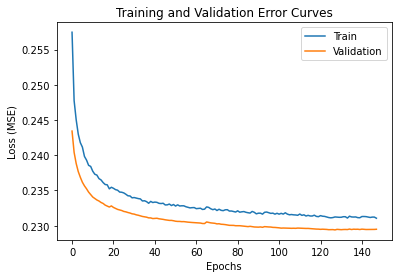

In [ ]:
plot_training_error_curves(history8)

In [ ]:
mlp_y_pred_class_8 = (classifier8.predict(x_test) > 0.5).astype("int32")
mlp_y_pred_scores_8 = classifier8.predict(x_test)
mlp_y_pred_scores_0_8 = 1 - mlp_y_pred_scores_8
mlp_y_pred_scores_8 = np.concatenate([mlp_y_pred_scores_0_8, mlp_y_pred_scores_8], axis=1)

Matriz de confusão no conjunto de teste:


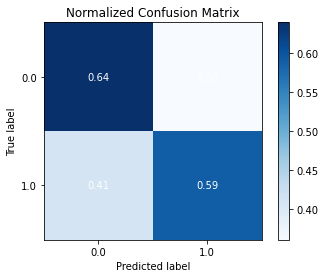

In [ ]:
print('Matriz de confusão no conjunto de teste:')

skplt.metrics.plot_confusion_matrix(y_test[:,0], mlp_y_pred_class_8, normalize=True)
plt.show()

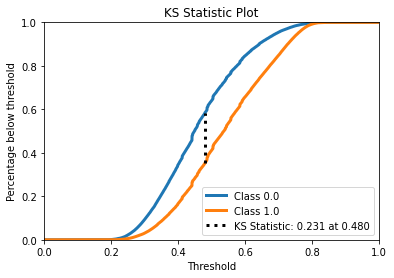


Accuracy:         0.6066
Recall:           0.5893
Precision:        0.7566
F1:               0.6626
AUROC:            0.6612
AUPR:             0.7777


In [ ]:
accuracy8, recall8, precision8, f18, auroc8, aupr8 = compute_performance_metrics(y_test[:,0], mlp_y_pred_class_8, mlp_y_pred_scores_8)
print_metrics_summary(accuracy8, recall8, precision8, f18, auroc8, aupr8)

## MLP Nona Versão 

Na nona versão, tentamos diminuir o learning rate, para ver se ele iria convergir melhor de acordo com as eṕocas.

In [ ]:
classifier9 = keras.Sequential([
    keras.Input(x_train.shape[1]),
    layers.Flatten(),
    layers.Dense(122, activation="tanh"),
    layers.Dropout(0.2),
    layers.Dense(122, activation="sigmoid"),
    layers.Dropout(0.2),
    layers.Dense(1, activation="sigmoid")
])

classifier9.compile(loss="mean_squared_error", optimizer=SGD(0.004), metrics=["accuracy"])

classifier9.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 243)               0         
                                                                 
 dense_12 (Dense)            (None, 122)               29768     
                                                                 
 dropout_7 (Dropout)         (None, 122)               0         
                                                                 
 dense_13 (Dense)            (None, 122)               15006     
                                                                 
 dropout_8 (Dropout)         (None, 122)               0         
                                                                 
 dense_14 (Dense)            (None, 1)                 123       
                                                                 
Total params: 44,897
Trainable params: 44,897
Non-trai

In [ ]:
history9 = classifier9.fit(tf.convert_to_tensor(x_train,np.float64),tf.convert_to_tensor(y_train[:,0],np.float64), batch_size=batch_size, epochs=epochs, 
                         callbacks=[EarlyStopping(patience=20)], validation_data=(tf.convert_to_tensor(x_valid,np.float64), tf.convert_to_tensor(y_valid[:,0],np.float64)))

Epoch 1/10000
3189/3189 [==============================] - 11s 3ms/step - loss: 0.2560 - accuracy: 0.5098 - val_loss: 0.2478 - val_accuracy: 0.5461
Epoch 2/10000
3189/3189 [==============================] - 10s 3ms/step - loss: 0.2531 - accuracy: 0.5191 - val_loss: 0.2464 - val_accuracy: 0.5633
Epoch 3/10000
3189/3189 [==============================] - 9s 3ms/step - loss: 0.2506 - accuracy: 0.5296 - val_loss: 0.2454 - val_accuracy: 0.5685
Epoch 4/10000
3189/3189 [==============================] - 10s 3ms/step - loss: 0.2494 - accuracy: 0.5367 - val_loss: 0.2444 - val_accuracy: 0.5758
Epoch 5/10000
3189/3189 [==============================] - 10s 3ms/step - loss: 0.2480 - accuracy: 0.5423 - val_loss: 0.2437 - val_accuracy: 0.5788
Epoch 6/10000
3189/3189 [==============================] - 10s 3ms/step - loss: 0.2470 - accuracy: 0.5490 - val_loss: 0.2429 - val_accuracy: 0.5819
Epoch 7/10000
3189/3189 [==============================] - 10s 3ms/step - loss: 0.2460 - accuracy: 0.5547 - val_l

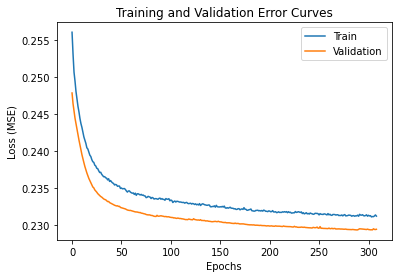

In [ ]:
plot_training_error_curves(history9)

In [ ]:
mlp_y_pred_class_9 = (classifier9.predict(x_test) > 0.5).astype("int32")
mlp_y_pred_scores_9 = classifier9.predict(x_test)
mlp_y_pred_scores_0_9 = 1 - mlp_y_pred_scores_9
mlp_y_pred_scores_9 = np.concatenate([mlp_y_pred_scores_0_9, mlp_y_pred_scores_9], axis=1)

Matriz de confusão no conjunto de teste:


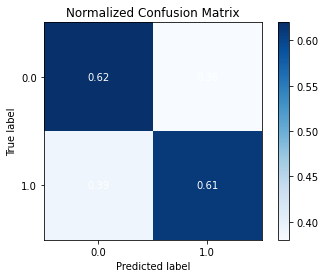

In [ ]:
print('Matriz de confusão no conjunto de teste:')

skplt.metrics.plot_confusion_matrix(y_test[:,0], mlp_y_pred_class_9, normalize=True)
plt.show()

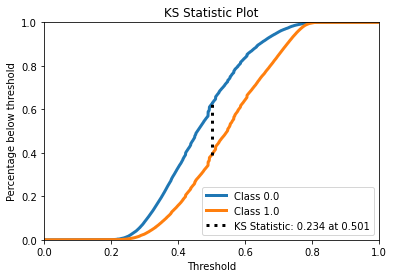


Accuracy:         0.6151
Recall:           0.6111
Precision:        0.7550
F1:               0.6755
AUROC:            0.6618
AUPR:             0.7788


In [ ]:
accuracy9, recall9, precision9, f19, auroc9, aupr9 = compute_performance_metrics(y_test[:,0], mlp_y_pred_class_9, mlp_y_pred_scores_9)
print_metrics_summary(accuracy9, recall9, precision9, f19, auroc9, aupr9)

## Random Forest Primeira Versão
O segundo modelo que nós vamos usar é uma random forest.
Começaremos inicialmente usando os valores padrões que temos no SkLearn.

In [ ]:
#Função auxiliar para o modelo de Random Forest

def graphs2(classifier):

  y_test_pred = np.argmax(y_test, axis=1)

  y_pred_class=np.argmax(classifier.predict(x_test), axis=1)

  y_pred_scores = classifier.predict(x_test) 
  y_pred_scores_0 = 1 - y_pred_scores
  y_pred_scores = np.concatenate([y_pred_scores_0, y_pred_scores], axis=1)

  skplt.metrics.plot_confusion_matrix(y_test_pred, y_pred_class, normalize=True)
  plt.show()

  return compute_performance_metrics(y_test_pred, y_pred_class)

In [ ]:

rfc = RandomForestClassifier(n_estimators=100, max_depth=None, max_features='auto', min_samples_leaf=1)
rfc.fit(x_train, y_train)

rfc.score(x_test, y_test)

0.6563855372155646

In [ ]:
y_test_pred = np.argmax(y_test, axis=1)

predict_prob = rfc.predict_proba(x_test)

probs_test = np.array(predict_prob)[1]


Performance no conjunto de teste:


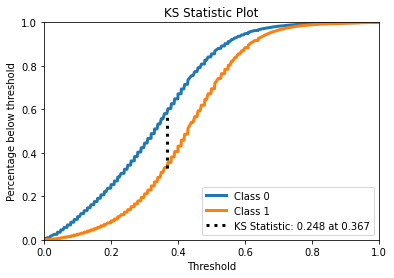

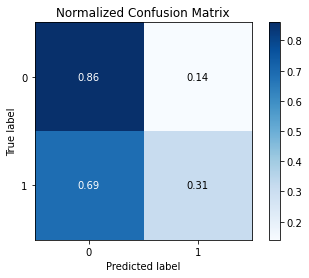


Accuracy:           0.6657     
Recall:             0.3054     
Precision:          0.5257     
F1:                 0.3863     
AUROC:              0.6678     
AUPR:               0.4755     


In [ ]:
print('\nPerformance no conjunto de teste:')
skplt.metrics.plot_ks_statistic(y_test_pred, probs_test)
plt.show()
probs_test = probs_test[:, 1]
auroc = roc_auc_score(y_test_pred, probs_test)
aupr = average_precision_score(y_test_pred, probs_test)

accuracy, recall, precision, f1 = graphs2(rfc)

print()
metrics = ['Accuracy:', 'Recall:', 'Precision:', 'F1:', 'AUROC:', 'AUPR:']
spc = ''
print(f'{metrics[0]: <18} {accuracy: .4f} {spc: <4}')
print(f'{metrics[1]: <18} {recall: .4f} {spc: <4}')
print(f'{metrics[2]: <18} {precision: .4f} {spc: <4}')
print(f'{metrics[3]: <18} {f1: .4f} {spc: <4}')
if auroc is not None:
  print(f'{metrics[4]: <18} {auroc: .4f} {spc: <4}')
if aupr is not None:
  print(f'{metrics[5]: <18} {aupr: .4f} {spc: <4}')

## Random Forest Segunda Versão
Para a segunda versão, decidimos aumentar o max_depth de cada árvore e comparar os resultados

In [ ]:
rfc2 = RandomForestClassifier(n_estimators=100, max_depth=20, max_features='auto', min_samples_leaf=1)
rfc2.fit(x_train, y_train)

rfc2.score(x_test, y_test)

0.6600135665686859

In [ ]:
y_test_pred2 = np.argmax(y_test, axis=1)

predict_prob2 = rfc2.predict_proba(x_test)

probs_test2 = np.array(predict_prob2)[1]


Performance no conjunto de teste:


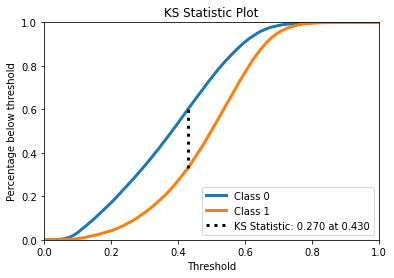

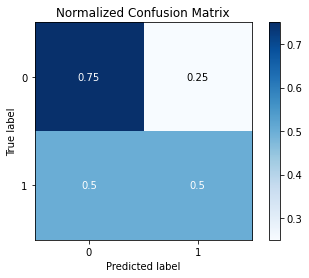


Accuracy:           0.6600     ↓
Recall:             0.4979     ↑
Precision:          0.5067     ↓
F1:                 0.5023     ↑
AUROC:              0.6843     ↑
AUPR:               0.5066     ↑


In [ ]:
print('\nPerformance no conjunto de teste:')
skplt.metrics.plot_ks_statistic(y_test_pred2, probs_test2)
plt.show()
probs_test2 = probs_test2[:, 1]
auroc2 = roc_auc_score(y_test_pred2, probs_test2)
aupr2 = average_precision_score(y_test_pred2, probs_test2)

accuracy2, recall2, precision2, f12 = graphs2(rfc2)

print()
metrics = ['Accuracy:', 'Recall:', 'Precision:', 'F1:', 'AUROC:', 'AUPR:']
spc = ''
print(f'{metrics[0]: <18} {accuracy2: .4f} {spc: <4}' + (colored('\u2191', 'green') if (accuracy2 > accuracy) else (colored('\u2193', 'red' if (accuracy2 < accuracy) else ('')))))
print(f'{metrics[1]: <18} {recall2: .4f} {spc: <4}' + (colored('\u2191', 'green') if (recall2 > recall) else (colored('\u2193', 'red') if (recall2 < recall) else (''))))
print(f'{metrics[2]: <18} {precision2: .4f} {spc: <4}' + (colored('\u2191', 'green') if (precision2 > precision) else (colored('\u2193', 'red') if (precision2 < precision) else (''))))
print(f'{metrics[3]: <18} {f12: .4f} {spc: <4}' + (colored('\u2191', 'green') if (f12 > f1) else (colored('\u2193', 'red') if (f12 < f1) else (''))))
if auroc2 is not None:
  print(f'{metrics[4]: <18} {auroc2: .4f} {spc: <4}' + (colored('\u2191', 'green') if (auroc2 > auroc) else (colored('\u2193', 'red') if (auroc2 < auroc) else (''))))
if aupr2 is not None:
  print(f'{metrics[5]: <18} {aupr2: .4f} {spc: <4}' + (colored('\u2191', 'green') if (aupr2 > aupr) else (colored('\u2193', 'red') if (aupr2 < aupr) else (''))))

Apesar de ter diminuido a Accuracy e a Precision, tivemos uma melhora significativa nos outros valores e no KS também

## Random Forest Terceira Versão
Agora iremos tentar diminuir a profundidade máxima de cada árvore porque talvez estejamos tendo overfitting

In [ ]:
rfc3 = RandomForestClassifier(n_estimators=50, max_depth=5, max_features='auto', min_samples_leaf=1)
rfc3.fit(x_train, y_train)

rfc3.score(x_test, y_test)

0.5968981890686345

In [ ]:
y_test_pred3 = np.argmax(y_test, axis=1)

predict_prob3 = rfc3.predict_proba(x_test)

probs_test3 = np.array(predict_prob3)[1]


Performance no conjunto de teste:


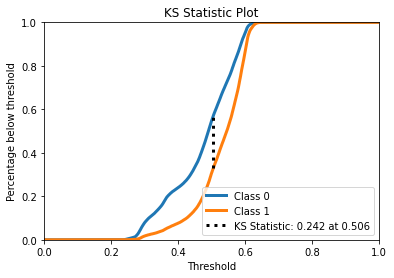

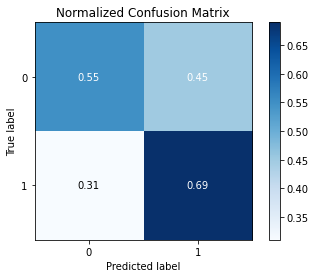


Accuracy:           0.5969     ↓
Recall:             0.6945     ↑
Precision:          0.4455     ↓
F1:                 0.5428     ↑
AUROC:              0.6696     ↓
AUPR:               0.4978     ↓


In [ ]:
print('\nPerformance no conjunto de teste:')
skplt.metrics.plot_ks_statistic(y_test_pred3, probs_test3)
plt.show()
probs_test3 = probs_test3[:, 1]
auroc3 = roc_auc_score(y_test_pred3, probs_test3)
aupr3 = average_precision_score(y_test_pred3, probs_test3)

accuracy3, recall3, precision3, f13 = graphs2(rfc3)

print()
metrics = ['Accuracy:', 'Recall:', 'Precision:', 'F1:', 'AUROC:', 'AUPR:']
spc = ''
print(f'{metrics[0]: <18} {accuracy3: .4f} {spc: <4}' + (colored('\u2191', 'green') if (accuracy3 > accuracy2) else (colored('\u2193', 'red' if (accuracy3 < accuracy2) else ('')))))
print(f'{metrics[1]: <18} {recall3: .4f} {spc: <4}' + (colored('\u2191', 'green') if (recall3 > recall2) else (colored('\u2193', 'red') if (recall3 < recall2) else (''))))
print(f'{metrics[2]: <18} {precision3: .4f} {spc: <4}' + (colored('\u2191', 'green') if (precision3 > precision2) else (colored('\u2193', 'red') if (precision3 < precision2) else (''))))
print(f'{metrics[3]: <18} {f13: .4f} {spc: <4}' + (colored('\u2191', 'green') if (f13 > f12) else (colored('\u2193', 'red') if (f13 < f12) else (''))))
if auroc3 is not None:
  print(f'{metrics[4]: <18} {auroc3: .4f} {spc: <4}' + (colored('\u2191', 'green') if (auroc3 > auroc2) else (colored('\u2193', 'red') if (auroc3 < auroc2) else (''))))
if aupr3 is not None:
  print(f'{metrics[5]: <18} {aupr3: .4f} {spc: <4}' + (colored('\u2191', 'green') if (aupr3 > aupr2) else (colored('\u2193', 'red') if (aupr3 < aupr2) else (''))))

Obtivemos uma certa piora na maioria das avaliações mas tivemos uma melhora significativa no Recall, além do F1.

## Random Forest Quarta Versão

Buscando agora melhorar os resultados das métricas, tentamos aumentar o tempo de treinamento do nosso classificador aumentando o numero de arvores, a profundidade de cada uma e outros parametros novos.

In [ ]:
rfc4 = RandomForestClassifier(n_estimators=100, max_depth=10, max_features='auto', min_samples_leaf=2, min_samples_split=5, bootstrap=True)
rfc4.fit(x_train, y_train)

rfc4.score(x_test, y_test)

0.619879134206253

In [ ]:
y_test_pred4 = np.argmax(y_test, axis=1)

predict_prob4 = rfc4.predict_proba(x_test)

probs_test4 = np.array(predict_prob4)[1]


Performance no conjunto de teste:


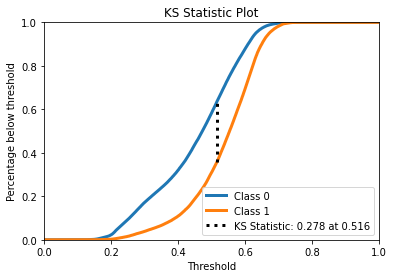

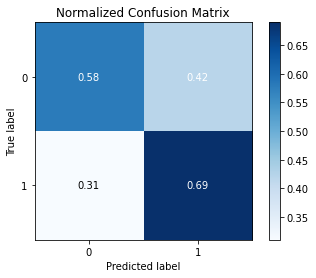


Accuracy:           0.6199     ↑
Recall:             0.6912     ↓
Precision:          0.4653     ↑
F1:                 0.5561     ↑
AUROC:              0.6915     ↑
AUPR:               0.5231     ↑


In [ ]:
print('\nPerformance no conjunto de teste:')
skplt.metrics.plot_ks_statistic(y_test_pred4, probs_test4)
plt.show()
probs_test4 = probs_test4[:, 1]
auroc4 = roc_auc_score(y_test_pred4, probs_test4)
aupr4 = average_precision_score(y_test_pred4, probs_test4)

accuracy4, recall4, precision4, f14 = graphs2(rfc4)

print()
metrics = ['Accuracy:', 'Recall:', 'Precision:', 'F1:', 'AUROC:', 'AUPR:']
spc = ''
print(f'{metrics[0]: <18} {accuracy4: .4f} {spc: <4}' + (colored('\u2191', 'green') if (accuracy4 > accuracy3) else (colored('\u2193', 'red' if (accuracy4 < accuracy3) else ('')))))
print(f'{metrics[1]: <18} {recall4: .4f} {spc: <4}' + (colored('\u2191', 'green') if (recall4 > recall3) else (colored('\u2193', 'red') if (recall4 < recall3) else (''))))
print(f'{metrics[2]: <18} {precision4: .4f} {spc: <4}' + (colored('\u2191', 'green') if (precision4 > precision3) else (colored('\u2193', 'red') if (precision4 < precision3) else (''))))
print(f'{metrics[3]: <18} {f14: .4f} {spc: <4}' + (colored('\u2191', 'green') if (f14 > f13) else (colored('\u2193', 'red') if (f14 < f13) else (''))))
if auroc3 is not None:
  print(f'{metrics[4]: <18} {auroc4: .4f} {spc: <4}' + (colored('\u2191', 'green') if (auroc4 > auroc3) else (colored('\u2193', 'red') if (auroc4 < auroc3) else (''))))
if aupr3 is not None:
  print(f'{metrics[5]: <18} {aupr4: .4f} {spc: <4}' + (colored('\u2191', 'green') if (aupr4 > aupr3) else (colored('\u2193', 'red') if (aupr4 < aupr3) else (''))))

Dessa vez, apesar da diminuição do Recall e KS, obtivemos melhora em todas as outras avaliações.

## Random Forest Quinta Versão
Para o último teste iremos tentar explorar os máximos dos parâmetros para tentar melhorar o resultado da accuracy e deixar o modelo treinar mais tempo.

In [ ]:
rfc5 = RandomForestClassifier(n_estimators=75, max_depth=9, max_features='auto', min_samples_leaf=1, min_samples_split=2, bootstrap=True)
rfc5.fit(x_train, y_train)

rfc5.score(x_test, y_test)

0.6172069312832741

In [ ]:
y_test_pred5 = np.argmax(y_test, axis=1)

predict_prob5 = rfc5.predict_proba(x_test)

probs_test5 = np.array(predict_prob5)[1]


Performance no conjunto de teste:


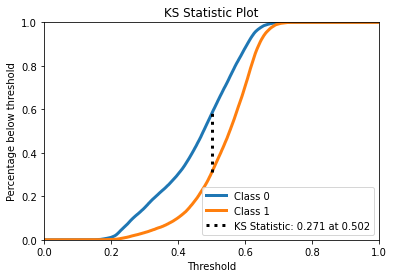

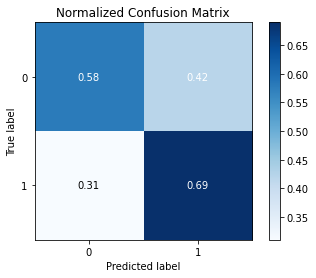


Accuracy:           0.6172     ↓
Recall:             0.6929     ↑
Precision:          0.4629     ↓
F1:                 0.5550     ↓
AUROC:              0.6881     ↓
AUPR:               0.5193     ↓


In [ ]:
print('\nPerformance no conjunto de teste:')
skplt.metrics.plot_ks_statistic(y_test_pred5, probs_test5)
plt.show()
probs_test5 = probs_test5[:, 1]
auroc5 = roc_auc_score(y_test_pred5, probs_test5)
aupr5 = average_precision_score(y_test_pred5, probs_test5)

accuracy5, recall5, precision5, f15 = graphs2(rfc5)

print()
metrics = ['Accuracy:', 'Recall:', 'Precision:', 'F1:', 'AUROC:', 'AUPR:']
spc = ''
print(f'{metrics[0]: <18} {accuracy5: .4f} {spc: <4}' + (colored('\u2191', 'green') if (accuracy5 > accuracy4) else (colored('\u2193', 'red' if (accuracy5 < accuracy4) else ('')))))
print(f'{metrics[1]: <18} {recall5: .4f} {spc: <4}' + (colored('\u2191', 'green') if (recall5 > recall4) else (colored('\u2193', 'red') if (recall5 < recall4) else (''))))
print(f'{metrics[2]: <18} {precision5: .4f} {spc: <4}' + (colored('\u2191', 'green') if (precision5 > precision4) else (colored('\u2193', 'red') if (precision5 < precision4) else (''))))
print(f'{metrics[3]: <18} {f15: .4f} {spc: <4}' + (colored('\u2191', 'green') if (f15 > f14) else (colored('\u2193', 'red') if (f15 < f14) else (''))))
if auroc3 is not None:
  print(f'{metrics[4]: <18} {auroc5: .4f} {spc: <4}' + (colored('\u2191', 'green') if (auroc5 > auroc4) else (colored('\u2193', 'red') if (auroc5 < auroc4) else (''))))
if aupr3 is not None:
  print(f'{metrics[5]: <18} {aupr5: .4f} {spc: <4}' + (colored('\u2191', 'green') if (aupr5 > aupr4) else (colored('\u2193', 'red') if (aupr5 < aupr4) else (''))))

## Gradient Boosting Primeira versão

Utilizamos os valores default da biblioteca XGBoost, com numero de rounds de 10000 e com paciência de 10

In [ ]:
y_train_xgb = y_train[:,0]
y_test_xgb = y_test[:,0]
y_valid_xgb = y_valid[:,0]

In [ ]:
xgb_clf = xgb.XGBClassifier(n_estimators=10000)

xgb_clf = xgb_clf.fit(x_train, y_train_xgb, early_stopping_rounds=10, eval_metric="rmse", eval_set=[(x_valid, y_valid_xgb)])

[0]	validation_0-rmse:0.49688
Will train until validation_0-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:0.494351
[2]	validation_0-rmse:0.492147
[3]	validation_0-rmse:0.490481
[4]	validation_0-rmse:0.488826
[5]	validation_0-rmse:0.487488
[6]	validation_0-rmse:0.486082
[7]	validation_0-rmse:0.48497
[8]	validation_0-rmse:0.483909
[9]	validation_0-rmse:0.482526
[10]	validation_0-rmse:0.481791
[11]	validation_0-rmse:0.481046
[12]	validation_0-rmse:0.480381
[13]	validation_0-rmse:0.479767
[14]	validation_0-rmse:0.479046
[15]	validation_0-rmse:0.478576
[16]	validation_0-rmse:0.477935
[17]	validation_0-rmse:0.477467
[18]	validation_0-rmse:0.477084
[19]	validation_0-rmse:0.476742
[20]	validation_0-rmse:0.476293
[21]	validation_0-rmse:0.475912
[22]	validation_0-rmse:0.475384
[23]	validation_0-rmse:0.475103
[24]	validation_0-rmse:0.474856
[25]	validation_0-rmse:0.474584
[26]	validation_0-rmse:0.474243
[27]	validation_0-rmse:0.473811
[28]	validation_0-rmse:0.473553
[29]	validation_0-r

In [ ]:
xgb_predict = xgb_clf.predict(x_test)
xgb_predict_proba = xgb_clf.predict_proba(x_test)

Matriz de confusão no conjunto de teste:


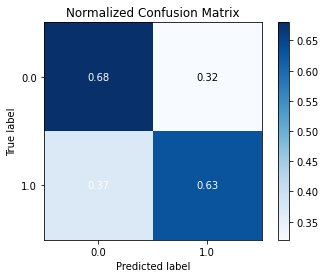

In [ ]:
print('Matriz de confusão no conjunto de teste:')

skplt.metrics.plot_confusion_matrix(y_test_xgb, xgb_predict, normalize=True)
plt.show()

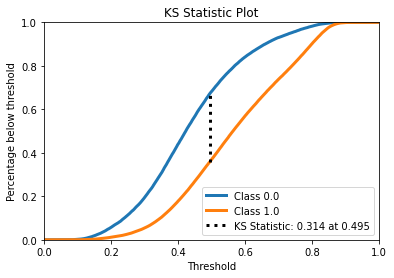


Accuracy:         0.6487
Recall:           0.6313
Precision:        0.7905
F1:               0.7020
AUROC:            0.7132
AUPR:             0.8164


In [ ]:
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_test_xgb, xgb_predict, xgb_predict_proba)
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

## Gradient Boosting Segunda versão

Testamos valores de subsample que determina a fração da quantidade dos samples totais que será utilizada para treinar os estimadores base.

In [ ]:
xgb_clf2 = xgb.XGBClassifier(n_estimators=10000, subsample=0.5)

xgb_clf2 = xgb_clf2.fit(x_train, y_train_xgb, early_stopping_rounds=10, eval_metric="rmse", eval_set=[(x_valid, y_valid_xgb)])


[0]	validation_0-rmse:0.496892
Will train until validation_0-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:0.494202
[2]	validation_0-rmse:0.49217
[3]	validation_0-rmse:0.490261
[4]	validation_0-rmse:0.488667
[5]	validation_0-rmse:0.487233
[6]	validation_0-rmse:0.485643
[7]	validation_0-rmse:0.484366
[8]	validation_0-rmse:0.483364
[9]	validation_0-rmse:0.482543
[10]	validation_0-rmse:0.481755
[11]	validation_0-rmse:0.480943
[12]	validation_0-rmse:0.480224
[13]	validation_0-rmse:0.479647
[14]	validation_0-rmse:0.479049
[15]	validation_0-rmse:0.47854
[16]	validation_0-rmse:0.477802
[17]	validation_0-rmse:0.477355
[18]	validation_0-rmse:0.476968
[19]	validation_0-rmse:0.476652
[20]	validation_0-rmse:0.476274
[21]	validation_0-rmse:0.47559
[22]	validation_0-rmse:0.475121
[23]	validation_0-rmse:0.474843
[24]	validation_0-rmse:0.474532
[25]	validation_0-rmse:0.474282
[26]	validation_0-rmse:0.473835
[27]	validation_0-rmse:0.473514
[28]	validation_0-rmse:0.473171
[29]	validation_0-rm

In [ ]:
xgb_predict2 = xgb_clf2.predict(x_test)
xgb_predict_proba2 = xgb_clf2.predict_proba(x_test)

Matriz de confusão no conjunto de teste:


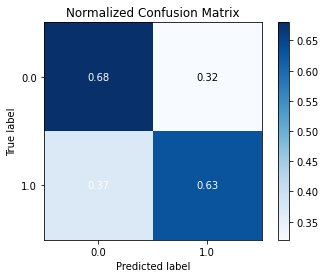

In [ ]:
print('Matriz de confusão no conjunto de teste:')

skplt.metrics.plot_confusion_matrix(y_test_xgb, xgb_predict2, normalize=True)
plt.show()

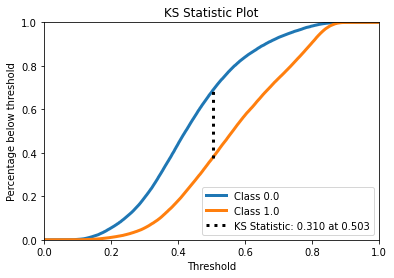


Accuracy:         0.6468
Recall:           0.6300
Precision:        0.7886
F1:               0.7004
AUROC:            0.7112
AUPR:             0.8145


In [ ]:
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_test_xgb, xgb_predict2, xgb_predict_proba2)
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

## Gradient Boosting Terceira versão

Aumentamos mais a quantidade de subsample para ver se o nosso modelo considerasse mais samples

In [ ]:
xgb_clf3 = xgb.XGBClassifier(n_estimators=10000, subsample=0.8)

xgb_clf3 = xgb_clf3.fit(x_train, y_train_xgb, early_stopping_rounds=10, eval_metric="rmse", eval_set=[(x_valid, y_valid_xgb)])


[0]	validation_0-rmse:0.496814
Will train until validation_0-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:0.494289
[2]	validation_0-rmse:0.492106
[3]	validation_0-rmse:0.490358
[4]	validation_0-rmse:0.488849
[5]	validation_0-rmse:0.487418
[6]	validation_0-rmse:0.485693
[7]	validation_0-rmse:0.484401
[8]	validation_0-rmse:0.483452
[9]	validation_0-rmse:0.482512
[10]	validation_0-rmse:0.481648
[11]	validation_0-rmse:0.480957
[12]	validation_0-rmse:0.480255
[13]	validation_0-rmse:0.479684
[14]	validation_0-rmse:0.47907
[15]	validation_0-rmse:0.478622
[16]	validation_0-rmse:0.4779
[17]	validation_0-rmse:0.477506
[18]	validation_0-rmse:0.476736
[19]	validation_0-rmse:0.476272
[20]	validation_0-rmse:0.47595
[21]	validation_0-rmse:0.475446
[22]	validation_0-rmse:0.47516
[23]	validation_0-rmse:0.474874
[24]	validation_0-rmse:0.474368
[25]	validation_0-rmse:0.474106
[26]	validation_0-rmse:0.473706
[27]	validation_0-rmse:0.473493
[28]	validation_0-rmse:0.4733
[29]	validation_0-rmse:0

In [ ]:
xgb_predict3 = xgb_clf3.predict(x_test)
xgb_predict_proba3 = xgb_clf3.predict_proba(x_test)

Matriz de confusão no conjunto de teste:


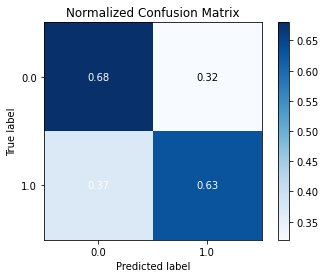

In [ ]:
print('Matriz de confusão no conjunto de teste:')

skplt.metrics.plot_confusion_matrix(y_test_xgb, xgb_predict3, normalize=True)
plt.show()

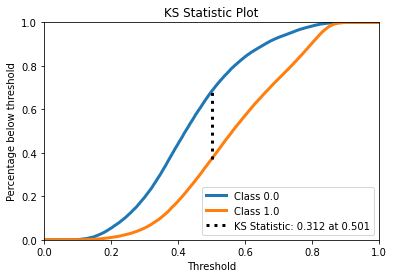


Accuracy:         0.6479
Recall:           0.6301
Precision:        0.7902
F1:               0.7011
AUROC:            0.7130
AUPR:             0.8157


In [ ]:
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_test_xgb, xgb_predict3, xgb_predict_proba3)
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

## Gradient Boosting Quarta versão

Aumentamos a max_depth, que foi do seu valor padrão de 6 para 10.

In [ ]:
xgb_clf4 = xgb.XGBClassifier(n_estimators=10000, subsample=0.8, max_depth= 10)

xgb_clf4 = xgb_clf4.fit(x_train, y_train_xgb, early_stopping_rounds=10, eval_metric="rmse", eval_set=[(x_valid, y_valid_xgb)])


[0]	validation_0-rmse:0.494645
Will train until validation_0-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:0.490287
[2]	validation_0-rmse:0.486744
[3]	validation_0-rmse:0.483746
[4]	validation_0-rmse:0.481264
[5]	validation_0-rmse:0.479163
[6]	validation_0-rmse:0.477377
[7]	validation_0-rmse:0.475961
[8]	validation_0-rmse:0.474555
[9]	validation_0-rmse:0.473461
[10]	validation_0-rmse:0.472609
[11]	validation_0-rmse:0.471855
[12]	validation_0-rmse:0.471201
[13]	validation_0-rmse:0.470747
[14]	validation_0-rmse:0.470349
[15]	validation_0-rmse:0.469885
[16]	validation_0-rmse:0.469521
[17]	validation_0-rmse:0.469266
[18]	validation_0-rmse:0.468946
[19]	validation_0-rmse:0.468699
[20]	validation_0-rmse:0.468474
[21]	validation_0-rmse:0.468253
[22]	validation_0-rmse:0.468172
[23]	validation_0-rmse:0.468071
[24]	validation_0-rmse:0.467953
[25]	validation_0-rmse:0.467902
[26]	validation_0-rmse:0.467883
[27]	validation_0-rmse:0.467814
[28]	validation_0-rmse:0.46773
[29]	validation_0-

In [ ]:
xgb_predict4 = xgb_clf4.predict(x_test)
xgb_predict_proba4 = xgb_clf4.predict_proba(x_test)

Matriz de confusão no conjunto de teste:


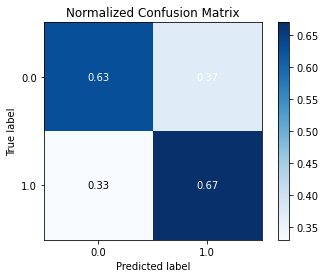

In [ ]:
print('Matriz de confusão no conjunto de teste:')

skplt.metrics.plot_confusion_matrix(y_test_xgb, xgb_predict4, normalize=True)
plt.show()

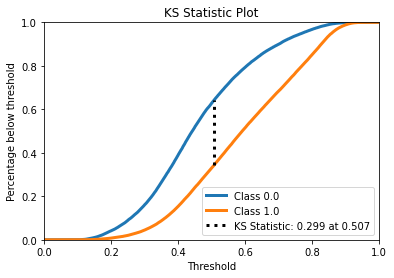


Accuracy:         0.6559
Recall:           0.6708
Precision:        0.7740
F1:               0.7187
AUROC:            0.7057
AUPR:             0.8116


In [ ]:
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_test_xgb, xgb_predict4, xgb_predict_proba4)
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

## Gradient Boosting Quinta versão

Como ele parou de treinar muito mais cedo que os outros modelos até então, e foi o melhor até agora, vamos tentar aumentando a paciência para 20 e ver se ele vai continuar melhorando ou apresentar overfitting.

In [ ]:
xgb_clf5 = xgb.XGBClassifier(n_estimators=10000, subsample=0.8, max_depth= 10)

xgb_clf5 = xgb_clf5.fit(x_train, y_train_xgb, early_stopping_rounds=20, eval_metric="rmse", eval_set=[(x_valid, y_valid_xgb)])


[0]	validation_0-rmse:0.494645
Will train until validation_0-rmse hasn't improved in 20 rounds.
[1]	validation_0-rmse:0.490287
[2]	validation_0-rmse:0.486744
[3]	validation_0-rmse:0.483746
[4]	validation_0-rmse:0.481264
[5]	validation_0-rmse:0.479163
[6]	validation_0-rmse:0.477377
[7]	validation_0-rmse:0.475961
[8]	validation_0-rmse:0.474555
[9]	validation_0-rmse:0.473461
[10]	validation_0-rmse:0.472609
[11]	validation_0-rmse:0.471855
[12]	validation_0-rmse:0.471201
[13]	validation_0-rmse:0.470747
[14]	validation_0-rmse:0.470349
[15]	validation_0-rmse:0.469885
[16]	validation_0-rmse:0.469521
[17]	validation_0-rmse:0.469266
[18]	validation_0-rmse:0.468946
[19]	validation_0-rmse:0.468699
[20]	validation_0-rmse:0.468474
[21]	validation_0-rmse:0.468253
[22]	validation_0-rmse:0.468172
[23]	validation_0-rmse:0.468071
[24]	validation_0-rmse:0.467953
[25]	validation_0-rmse:0.467902
[26]	validation_0-rmse:0.467883
[27]	validation_0-rmse:0.467814
[28]	validation_0-rmse:0.46773
[29]	validation_0-

In [ ]:
xgb_predict5 = xgb_clf5.predict(x_test)
xgb_predict_proba5 = xgb_clf5.predict_proba(x_test)

Matriz de confusão no conjunto de teste:


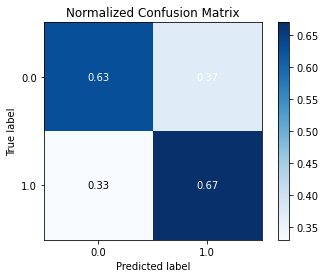

In [ ]:
print('Matriz de confusão no conjunto de teste:')

skplt.metrics.plot_confusion_matrix(y_test_xgb, xgb_predict5, normalize=True)
plt.show()

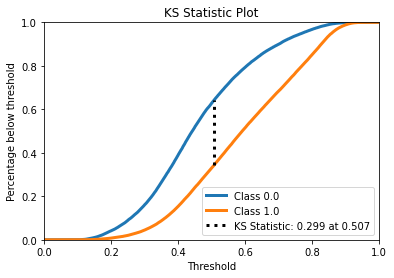


Accuracy:         0.6559
Recall:           0.6708
Precision:        0.7740
F1:               0.7187
AUROC:            0.7057
AUPR:             0.8116


In [ ]:
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_test_xgb, xgb_predict5, xgb_predict_proba5)
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

## Gradient Boosting Sexta versão

Com paciência 20 não se teve melhores, pois ele ainda pegou o mesmo modelo, então agora vamos diminuir o learning rate para 0.01 (default dele é 0.3) e aumentar a robustez do modelo.

In [ ]:
xgb_clf6 = xgb.XGBClassifier(n_estimators=10000, subsample=0.8, max_depth= 10, learning_rate=0.01)

xgb_clf6 = xgb_clf6.fit(x_train, y_train_xgb, early_stopping_rounds=20, eval_metric="rmse", eval_set=[(x_valid, y_valid_xgb)])


[0]	validation_0-rmse:0.499429
Will train until validation_0-rmse hasn't improved in 20 rounds.
[1]	validation_0-rmse:0.498871
[2]	validation_0-rmse:0.498346
[3]	validation_0-rmse:0.497806
[4]	validation_0-rmse:0.497283
[5]	validation_0-rmse:0.496769
[6]	validation_0-rmse:0.496275
[7]	validation_0-rmse:0.49577
[8]	validation_0-rmse:0.495271
[9]	validation_0-rmse:0.494792
[10]	validation_0-rmse:0.494323
[11]	validation_0-rmse:0.493866
[12]	validation_0-rmse:0.493414
[13]	validation_0-rmse:0.492965
[14]	validation_0-rmse:0.492521
[15]	validation_0-rmse:0.492094
[16]	validation_0-rmse:0.491673
[17]	validation_0-rmse:0.49127
[18]	validation_0-rmse:0.490852
[19]	validation_0-rmse:0.490449
[20]	validation_0-rmse:0.49005
[21]	validation_0-rmse:0.489669
[22]	validation_0-rmse:0.489297
[23]	validation_0-rmse:0.488933
[24]	validation_0-rmse:0.488571
[25]	validation_0-rmse:0.488216
[26]	validation_0-rmse:0.487858
[27]	validation_0-rmse:0.487515
[28]	validation_0-rmse:0.487176
[29]	validation_0-rm

In [ ]:
xgb_predict6 = xgb_clf6.predict(x_test)
xgb_predict_proba6 = xgb_clf6.predict_proba(x_test)

Matriz de confusão no conjunto de teste:


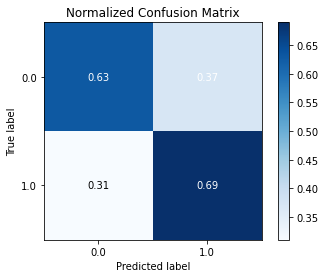

In [ ]:
print('Matriz de confusão no conjunto de teste:')

skplt.metrics.plot_confusion_matrix(y_test_xgb, xgb_predict6, normalize=True)
plt.show()

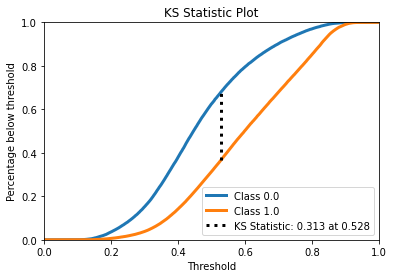


Accuracy:         0.6658
Recall:           0.6873
Precision:        0.7772
F1:               0.7294
AUROC:            0.7137
AUPR:             0.8170


In [ ]:
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_test_xgb, xgb_predict6, xgb_predict_proba6)
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

Esse foi o nosso melhor modelo utilizando o Xgboost, superior na maioria das métricas.

## Ensemble MLP Primeira Versão

In [ ]:
epochs = 10000
batch_size = 128
patience = 10

y_valid_mlp_ensemble = y_valid

In [ ]:
mlp_1 = keras.Sequential([
    keras.Input(x_train.shape[1]),
    layers.Flatten(),
    layers.Dense(100, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

mlp_1.compile(loss="mean_squared_error", optimizer=Adam(), metrics=["accuracy"])

mlp_1 = KerasClassifier(build_fn=mlp_1, epochs=15, batch_size=batch_size, verbose=0)

In [ ]:
mlp_4 = keras.Sequential([
    keras.Input(x_train.shape[1]),
    layers.Flatten(),
    layers.Dense(100, activation="tanh"),
    layers.Dense(1, activation="sigmoid")
])

mlp_4.compile(loss="mean_squared_error", optimizer=SGD(), metrics=["accuracy"])
mlp_4 = KerasClassifier(build_fn=mlp_4, epochs=118, batch_size=batch_size, verbose=0)

In [ ]:
mlp_7 = keras.Sequential([
    keras.Input(x_train.shape[1]),
    layers.Flatten(),
    layers.Dense(122, activation="relu"),
    layers.Dense(122, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

mlp_7.compile(loss="mean_squared_error", optimizer=SGD(), metrics=["accuracy"])
mlp_7 = KerasClassifier(build_fn=mlp_7, epochs=75, batch_size=batch_size, verbose=0)

In [ ]:
mlp_8 = keras.Sequential([
    keras.Input(x_train.shape[1]),
    layers.Flatten(),
    layers.Dense(100, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(100, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(1, activation="sigmoid")
])

mlp_8.compile(loss="mean_squared_error", optimizer=SGD(), metrics=["accuracy"])
mlp_8 = KerasClassifier(build_fn=mlp_8, epochs=120, batch_size=batch_size, verbose=0)

In [ ]:
mlp_9 = keras.Sequential([
    keras.Input(x_train.shape[1]),
    layers.Flatten(),
    layers.Dense(100, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(100, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(2, activation="sigmoid")
])

mlp_9.compile(loss="mean_squared_error", optimizer=SGD(0.004), metrics=["accuracy"])
mlp_9 = KerasClassifier(build_fn=mlp_9, epochs=170, batch_size=batch_size, verbose=0)

In [ ]:
models = [('mlp_1', mlp_1), ('mlp_4', mlp_4), ('mlp_7', mlp_7), ('mlp_8', mlp_8), ('mlp_9', mlp_9)]
ensemble = VotingClassifier(estimators=models, voting='soft', verbose=True)
history_ensemble_mlp = ensemble.fit(x_train, y_train[:,0])

INFO:tensorflow:Assets written to: ram://2f85c0d3-5684-4c18-a705-c7116deda104/assets


/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


[Voting] .................... (1 of 5) Processing mlp_1, total= 1.0min
INFO:tensorflow:Assets written to: ram://3b630745-0c04-44e0-af10-dbe23092e958/assets


/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


[Voting] .................... (2 of 5) Processing mlp_4, total= 7.4min
INFO:tensorflow:Assets written to: ram://1cbfb8a2-bc78-4ac5-ba08-dc42a36d7e14/assets


/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


[Voting] .................... (3 of 5) Processing mlp_7, total= 5.4min
INFO:tensorflow:Assets written to: ram://5670510b-8f38-4400-a28e-d6e2cd6c7584/assets


/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


[Voting] .................... (4 of 5) Processing mlp_8, total= 9.5min
INFO:tensorflow:Assets written to: ram://a2ffdf49-fd5f-42b1-8410-329047bb6145/assets


/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


[Voting] .................... (5 of 5) Processing mlp_9, total=13.3min


In [ ]:
mlp_ensemble_predict_1 = ensemble.predict(x_test)
mlp_ensemble_predict_proba_1 = ensemble.predict_proba(x_test)

Matriz de confusão no conjunto de teste:


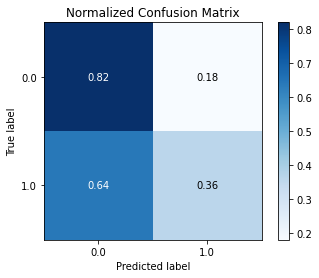

In [ ]:
print('Matriz de confusão no conjunto de teste:')

skplt.metrics.plot_confusion_matrix(y_test[:,0], mlp_ensemble_predict_1, normalize=True)
plt.show()

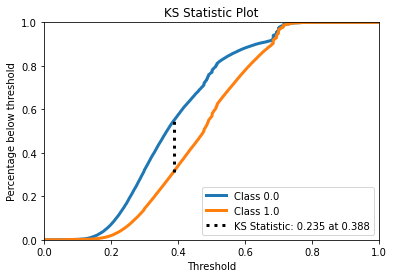


Accuracy:         0.5171
Recall:           0.3570
Precision:        0.7920
F1:               0.4922
AUROC:            0.6516
AUPR:             0.7437


In [ ]:
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_test[:,0], mlp_ensemble_predict_1, mlp_ensemble_predict_proba_1)
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

## Ensemble Classificadores Primeira Versão

Para fazer o primeiro ensemble, nós vamos usar a melhor versão de cada método que nós usamos, e usaramos o modelo de voting classifier, sendo que o método de votação será "soft".

In [ ]:
mlp_model = keras.Sequential([
    keras.Input(x_train.shape[1]),
    layers.Flatten(),
    layers.Dense(45, activation="tanh"),
    layers.Dense(1, activation="sigmoid")
])

mlp_model.compile(loss="mean_squared_error", optimizer=Adam(), metrics=["accuracy"])

best_rfc = RandomForestClassifier(n_estimators=100, max_depth=10, max_features='auto', min_samples_leaf=2, min_samples_split=5, bootstrap=True)
best_xgb = xgb.XGBClassifier(n_estimators=513, subsample=0.8, max_depth= 10, learning_rate=0.01)
best_mlp = KerasClassifier(build_fn=mlp_model, epochs=15, batch_size=128)
best_mlp._estimator_type = "classifier"
models = [('mlp', best_mlp),('random_fr', best_rfc), ('gboost', best_xgb)]

In [ ]:
ensemble1 = VotingClassifier(estimators=models, voting='soft', verbose=True)
ensemble1.fit(x_train, y_train[:,0])

INFO:tensorflow:Assets written to: ram:///tmp/tmpvby58idn/assets


/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


Epoch 1/15
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2358 - accuracy: 0.6013
Epoch 2/15
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2311 - accuracy: 0.6152
Epoch 3/15
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2300 - accuracy: 0.6172
Epoch 4/15
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2286 - accuracy: 0.6209
Epoch 5/15
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2278 - accuracy: 0.6227
Epoch 6/15
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2275 - accuracy: 0.6242
Epoch 7/15
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2267 - accuracy: 0.6242
Epoch 8/15
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2271 - accuracy: 0.6260
Epoch 9/15
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2256 - accuracy: 0.6286
Epoch 10/15
1993/1993 [==============================] - 4s 2ms/step - loss: 0.225

VotingClassifier(estimators=[('mlp',
                              KerasClassifier(batch_size=128, build_fn=<keras.engine.sequential.Sequential object at 0x7fd8fca9dc50>, epochs=15)),
                             ('random_fr',
                              RandomForestClassifier(max_depth=10,
                                                     min_samples_leaf=2,
                                                     min_samples_split=5)),
                             ('gboost',
                              XGBClassifier(learning_rate=0.01, max_depth=10,
                                            n_estimators=513, subsample=0.8))],
                 verbose=True, voting='soft')

In [ ]:
y_pred_ems1 = ensemble1.predict(x_test)

761/761 [==============================] - 1s 1ms/step


In [ ]:
y_pred_proba_ems1 = ensemble1.predict_proba(x_test)

761/761 [==============================] - 1s 1ms/step


Aqui nós temos a nossa matriz de confusão

  1/761 [..............................] - ETA: 12s

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


761/761 [==============================] - 1s 1ms/step


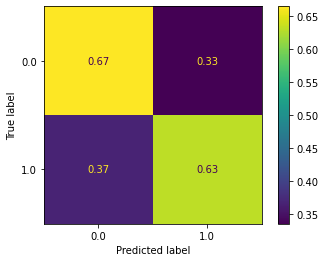

In [ ]:
plot_confusion_matrix(ensemble1, x_test, y_test[:,0], normalize='true')

E aqui as métricas conseguidas com o ensemble

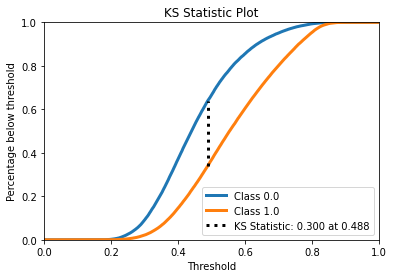


Accuracy:         0.6435
Recall:           0.6322
Precision:        0.7822
F1:               0.6992
AUROC:            0.7055
AUPR:             0.8118


In [ ]:
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_test[:,0], y_pred_ems1, y_pred_proba_ems1)
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

## Ensemble Classificadores Segunda Versão
Para o segundo ensemble, nós continuamos com o voting classifier, só que com o voting = "hard", que é o padrão do sklearn para o voting classifier.

In [ ]:
ensemble2 = VotingClassifier(estimators=models, voting='hard', verbose=True)
ensemble2.fit(x_train, y_train[:,0])

INFO:tensorflow:Assets written to: ram:///tmp/tmpqdwqo9kh/assets


/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


Epoch 1/15
1993/1993 [==============================] - 13s 6ms/step - loss: 0.2721 - accuracy: 0.6037
Epoch 2/15
1993/1993 [==============================] - 5s 3ms/step - loss: 0.2662 - accuracy: 0.6162
Epoch 3/15
1993/1993 [==============================] - 5s 3ms/step - loss: 0.2635 - accuracy: 0.6214
Epoch 4/15
1993/1993 [==============================] - 5s 3ms/step - loss: 0.2619 - accuracy: 0.6263
Epoch 5/15
1993/1993 [==============================] - 5s 3ms/step - loss: 0.2609 - accuracy: 0.6295
Epoch 6/15
1993/1993 [==============================] - 5s 3ms/step - loss: 0.2593 - accuracy: 0.6340
Epoch 7/15
1993/1993 [==============================] - 5s 3ms/step - loss: 0.2567 - accuracy: 0.6389
Epoch 8/15
1993/1993 [==============================] - 5s 3ms/step - loss: 0.2554 - accuracy: 0.6444
Epoch 9/15
1993/1993 [==============================] - 5s 2ms/step - loss: 0.2534 - accuracy: 0.6486
Epoch 10/15
1993/1993 [==============================] - 5s 3ms/step - loss: 0.25

VotingClassifier(estimators=[('mlp',
                              KerasClassifier(batch_size=128, build_fn=<keras.engine.sequential.Sequential object at 0x7fbf80c90790>, epochs=15)),
                             ('random_fr',
                              RandomForestClassifier(max_depth=10,
                                                     min_samples_leaf=2,
                                                     min_samples_split=5)),
                             ('gboost',
                              XGBClassifier(learning_rate=0.01, max_depth=10,
                                            n_estimators=513, subsample=0.8))],
                 verbose=True)

In [ ]:
y_pred_ems2 = ensemble2.predict(x_test)

761/761 [==============================] - 1s 2ms/step


Aqui nós temos a nossa matriz de confusão

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


761/761 [==============================] - 3s 4ms/step


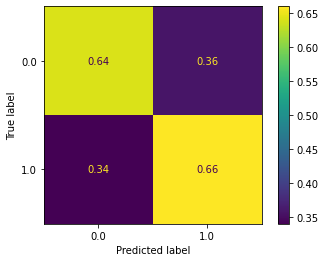

In [ ]:
plot_confusion_matrix(ensemble2, x_test, y_test[:,0], normalize='true')

E aqui as métricas conseguidas com o ensemble

In [ ]:
accuracy, recall, precision, f1 = compute_performance_metrics(y_test[:,0], y_pred_ems2)
print_metrics_summary(accuracy, recall, precision, f1)


Accuracy:         0.6534
Recall:           0.6594
Precision:        0.7779
F1:               0.7138


## Ensemble Classificadores Terceira Versão
Para o terceiro ensemble, nós vamos usar o bagging classifier, com 10 estimators e o nosso base estimator vai ser o melhor modelo de mlp que nós conseguimos até agora

In [ ]:
ensemble3 = BaggingClassifier(base_estimator=best_mlp, n_estimators=10, verbose=True)
ensemble3.fit(x_train, y_train[:,0])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


INFO:tensorflow:Assets written to: ram:///tmp/tmpdos4un5h/assets


/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


Epoch 1/15
1993/1993 [==============================] - 6s 3ms/step - loss: 0.2741 - accuracy: 0.5973
Epoch 2/15
1993/1993 [==============================] - 5s 3ms/step - loss: 0.2677 - accuracy: 0.6114
Epoch 3/15
1993/1993 [==============================] - 5s 3ms/step - loss: 0.2647 - accuracy: 0.6165
Epoch 4/15
1993/1993 [==============================] - 5s 3ms/step - loss: 0.2628 - accuracy: 0.6202
Epoch 5/15
1993/1993 [==============================] - 5s 3ms/step - loss: 0.2620 - accuracy: 0.6218
Epoch 6/15
1993/1993 [==============================] - 6s 3ms/step - loss: 0.2599 - accuracy: 0.6248
Epoch 7/15
1993/1993 [==============================] - 6s 3ms/step - loss: 0.2580 - accuracy: 0.6279
Epoch 8/15
1993/1993 [==============================] - 5s 3ms/step - loss: 0.2562 - accuracy: 0.6302
Epoch 9/15
1993/1993 [==============================] - 5s 3ms/step - loss: 0.2538 - accuracy: 0.6332
Epoch 10/15
1993/1993 [==============================] - 5s 3ms/step - loss: 0.252

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


Epoch 1/15
1993/1993 [==============================] - 6s 3ms/step - loss: 0.2737 - accuracy: 0.5980
Epoch 2/15
1993/1993 [==============================] - 5s 3ms/step - loss: 0.2687 - accuracy: 0.6118
Epoch 3/15
1993/1993 [==============================] - 5s 3ms/step - loss: 0.2656 - accuracy: 0.6159
Epoch 4/15
1993/1993 [==============================] - 5s 3ms/step - loss: 0.2641 - accuracy: 0.6187
Epoch 5/15
1993/1993 [==============================] - 5s 3ms/step - loss: 0.2619 - accuracy: 0.6227
Epoch 6/15
1993/1993 [==============================] - 5s 3ms/step - loss: 0.2604 - accuracy: 0.6250
Epoch 7/15
1993/1993 [==============================] - 6s 3ms/step - loss: 0.2575 - accuracy: 0.6297
Epoch 8/15
1993/1993 [==============================] - 6s 3ms/step - loss: 0.2562 - accuracy: 0.6310
Epoch 9/15
1993/1993 [==============================] - 6s 3ms/step - loss: 0.2541 - accuracy: 0.6336
Epoch 10/15
1993/1993 [==============================] - 5s 3ms/step - loss: 0.252

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


Epoch 1/15
1993/1993 [==============================] - 6s 3ms/step - loss: 0.2736 - accuracy: 0.5971
Epoch 2/15
1993/1993 [==============================] - 5s 3ms/step - loss: 0.2672 - accuracy: 0.6116
Epoch 3/15
1993/1993 [==============================] - 5s 3ms/step - loss: 0.2637 - accuracy: 0.6166
Epoch 4/15
1993/1993 [==============================] - 5s 3ms/step - loss: 0.2617 - accuracy: 0.6199
Epoch 5/15
1993/1993 [==============================] - 5s 3ms/step - loss: 0.2605 - accuracy: 0.6235
Epoch 6/15
1993/1993 [==============================] - 5s 3ms/step - loss: 0.2589 - accuracy: 0.6258
Epoch 7/15
1993/1993 [==============================] - 5s 3ms/step - loss: 0.2567 - accuracy: 0.6290
Epoch 8/15
1993/1993 [==============================] - 5s 3ms/step - loss: 0.2552 - accuracy: 0.6313
Epoch 9/15
1993/1993 [==============================] - 5s 3ms/step - loss: 0.2545 - accuracy: 0.6331
Epoch 10/15
1993/1993 [==============================] - 5s 3ms/step - loss: 0.250

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


Epoch 1/15
1993/1993 [==============================] - 6s 3ms/step - loss: 0.2743 - accuracy: 0.5964
Epoch 2/15
1993/1993 [==============================] - 5s 3ms/step - loss: 0.2673 - accuracy: 0.6127
Epoch 3/15
1993/1993 [==============================] - 5s 3ms/step - loss: 0.2644 - accuracy: 0.6171
Epoch 4/15
1993/1993 [==============================] - 5s 3ms/step - loss: 0.2632 - accuracy: 0.6213
Epoch 5/15
1993/1993 [==============================] - 5s 3ms/step - loss: 0.2608 - accuracy: 0.6242
Epoch 6/15
1993/1993 [==============================] - 5s 3ms/step - loss: 0.2572 - accuracy: 0.6283
Epoch 7/15
1993/1993 [==============================] - 5s 3ms/step - loss: 0.2543 - accuracy: 0.6324
Epoch 8/15
1993/1993 [==============================] - 5s 3ms/step - loss: 0.2524 - accuracy: 0.6351
Epoch 9/15
1993/1993 [==============================] - 5s 3ms/step - loss: 0.2500 - accuracy: 0.6384
Epoch 10/15
1993/1993 [==============================] - 5s 3ms/step - loss: 0.248

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


Epoch 1/15
1993/1993 [==============================] - 5s 3ms/step - loss: 0.2755 - accuracy: 0.5981
Epoch 2/15
1993/1993 [==============================] - 5s 3ms/step - loss: 0.2688 - accuracy: 0.6107
Epoch 3/15
1993/1993 [==============================] - 5s 3ms/step - loss: 0.2663 - accuracy: 0.6146
Epoch 4/15
1993/1993 [==============================] - 5s 3ms/step - loss: 0.2640 - accuracy: 0.6192
Epoch 5/15
1993/1993 [==============================] - 5s 3ms/step - loss: 0.2620 - accuracy: 0.6216
Epoch 6/15
1993/1993 [==============================] - 5s 3ms/step - loss: 0.2603 - accuracy: 0.6253
Epoch 7/15
1993/1993 [==============================] - 5s 3ms/step - loss: 0.2581 - accuracy: 0.6279
Epoch 8/15
1993/1993 [==============================] - 5s 3ms/step - loss: 0.2556 - accuracy: 0.6312
Epoch 9/15
1993/1993 [==============================] - 5s 3ms/step - loss: 0.2539 - accuracy: 0.6345
Epoch 10/15
1993/1993 [==============================] - 5s 3ms/step - loss: 0.252

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


Epoch 1/15
1993/1993 [==============================] - 5s 2ms/step - loss: 0.2740 - accuracy: 0.5989
Epoch 2/15
1993/1993 [==============================] - 5s 3ms/step - loss: 0.2688 - accuracy: 0.6115
Epoch 3/15
1993/1993 [==============================] - 5s 3ms/step - loss: 0.2659 - accuracy: 0.6159
Epoch 4/15
1993/1993 [==============================] - 5s 3ms/step - loss: 0.2653 - accuracy: 0.6183
Epoch 5/15
1993/1993 [==============================] - 5s 3ms/step - loss: 0.2638 - accuracy: 0.6204
Epoch 6/15
1993/1993 [==============================] - 5s 3ms/step - loss: 0.2620 - accuracy: 0.6233
Epoch 7/15
1993/1993 [==============================] - 5s 3ms/step - loss: 0.2605 - accuracy: 0.6256
Epoch 8/15
1993/1993 [==============================] - 5s 3ms/step - loss: 0.2587 - accuracy: 0.6282
Epoch 9/15
1993/1993 [==============================] - 5s 3ms/step - loss: 0.2571 - accuracy: 0.6306
Epoch 10/15
1993/1993 [==============================] - 5s 3ms/step - loss: 0.255

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


Epoch 1/15
1993/1993 [==============================] - 5s 3ms/step - loss: 0.2740 - accuracy: 0.5976
Epoch 2/15
1993/1993 [==============================] - 5s 3ms/step - loss: 0.2689 - accuracy: 0.6106
Epoch 3/15
1993/1993 [==============================] - 5s 3ms/step - loss: 0.2669 - accuracy: 0.6144
Epoch 4/15
1993/1993 [==============================] - 5s 3ms/step - loss: 0.2647 - accuracy: 0.6178
Epoch 5/15
1993/1993 [==============================] - 5s 3ms/step - loss: 0.2631 - accuracy: 0.6212
Epoch 6/15
1993/1993 [==============================] - 5s 3ms/step - loss: 0.2613 - accuracy: 0.6239
Epoch 7/15
1993/1993 [==============================] - 5s 3ms/step - loss: 0.2592 - accuracy: 0.6261
Epoch 8/15
1993/1993 [==============================] - 5s 3ms/step - loss: 0.2573 - accuracy: 0.6289
Epoch 9/15
1993/1993 [==============================] - 5s 3ms/step - loss: 0.2560 - accuracy: 0.6313
Epoch 10/15
1993/1993 [==============================] - 5s 3ms/step - loss: 0.253

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


Epoch 1/15
1993/1993 [==============================] - 6s 3ms/step - loss: 0.2756 - accuracy: 0.5977
Epoch 2/15
1993/1993 [==============================] - 5s 3ms/step - loss: 0.2705 - accuracy: 0.6095
Epoch 3/15
1993/1993 [==============================] - 5s 3ms/step - loss: 0.2682 - accuracy: 0.6140
Epoch 4/15
1993/1993 [==============================] - 5s 3ms/step - loss: 0.2651 - accuracy: 0.6181
Epoch 5/15
1993/1993 [==============================] - 5s 3ms/step - loss: 0.2634 - accuracy: 0.6208
Epoch 6/15
1993/1993 [==============================] - 5s 3ms/step - loss: 0.2597 - accuracy: 0.6257
Epoch 7/15
1993/1993 [==============================] - 5s 3ms/step - loss: 0.2559 - accuracy: 0.6296
Epoch 8/15
1993/1993 [==============================] - 5s 3ms/step - loss: 0.2536 - accuracy: 0.6326
Epoch 9/15
1993/1993 [==============================] - 5s 3ms/step - loss: 0.2519 - accuracy: 0.6353
Epoch 10/15
1993/1993 [==============================] - 5s 3ms/step - loss: 0.249

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


Epoch 1/15
1993/1993 [==============================] - 6s 3ms/step - loss: 0.2743 - accuracy: 0.5967
Epoch 2/15
1993/1993 [==============================] - 5s 3ms/step - loss: 0.2688 - accuracy: 0.6101
Epoch 3/15
1993/1993 [==============================] - 5s 3ms/step - loss: 0.2668 - accuracy: 0.6140
Epoch 4/15
1993/1993 [==============================] - 5s 3ms/step - loss: 0.2642 - accuracy: 0.6175
Epoch 5/15
1993/1993 [==============================] - 5s 3ms/step - loss: 0.2612 - accuracy: 0.6217
Epoch 6/15
1993/1993 [==============================] - 5s 3ms/step - loss: 0.2587 - accuracy: 0.6251
Epoch 7/15
1993/1993 [==============================] - 5s 3ms/step - loss: 0.2569 - accuracy: 0.6282
Epoch 8/15
1993/1993 [==============================] - 5s 3ms/step - loss: 0.2548 - accuracy: 0.6311
Epoch 9/15
1993/1993 [==============================] - 5s 3ms/step - loss: 0.2525 - accuracy: 0.6350
Epoch 10/15
1993/1993 [==============================] - 5s 3ms/step - loss: 0.249

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


Epoch 1/15
1993/1993 [==============================] - 6s 3ms/step - loss: 0.2743 - accuracy: 0.5962
Epoch 2/15
1993/1993 [==============================] - 6s 3ms/step - loss: 0.2688 - accuracy: 0.6087
Epoch 3/15
1993/1993 [==============================] - 6s 3ms/step - loss: 0.2659 - accuracy: 0.6138
Epoch 4/15
1993/1993 [==============================] - 6s 3ms/step - loss: 0.2643 - accuracy: 0.6170
Epoch 5/15
1993/1993 [==============================] - 6s 3ms/step - loss: 0.2621 - accuracy: 0.6199
Epoch 6/15
1993/1993 [==============================] - 6s 3ms/step - loss: 0.2602 - accuracy: 0.6231
Epoch 7/15
1993/1993 [==============================] - 6s 3ms/step - loss: 0.2585 - accuracy: 0.6266
Epoch 8/15
1993/1993 [==============================] - 6s 3ms/step - loss: 0.2561 - accuracy: 0.6294
Epoch 9/15
1993/1993 [==============================] - 6s 3ms/step - loss: 0.2536 - accuracy: 0.6321
Epoch 10/15
1993/1993 [==============================] - 6s 3ms/step - loss: 0.251

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 21.4min finished


BaggingClassifier(base_estimator=KerasClassifier(batch_size=128, build_fn=<keras.engine.sequential.Sequential object at 0x7fd44e4c48d0>, epochs=15),
                  verbose=True)

In [ ]:
y_pred_ems3 = ensemble3.predict(x_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


761/761 [==============================] - 1s 2ms/step


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.0s finished


In [ ]:
y_pred_proba_ems3 = ensemble3.predict_proba(x_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


761/761 [==============================] - 1s 2ms/step


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   16.2s finished


Aqui nós temos a nossa matriz de confusão

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


761/761 [==============================] - 1s 2ms/step


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.7s finished


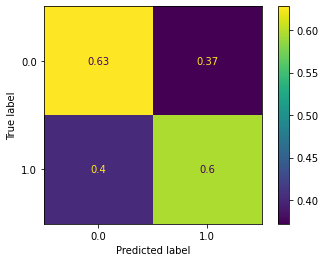

In [ ]:
plot_confusion_matrix(ensemble3, x_test, y_test[:,0], normalize='true')

E aqui as métricas conseguidas com o ensemble

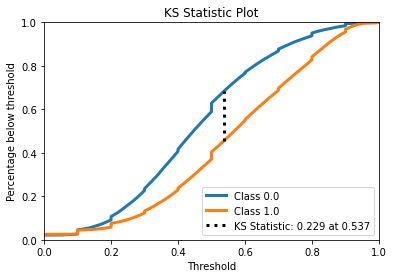


Accuracy:         0.6071
Recall:           0.5962
Precision:        0.7530
F1:               0.6655
AUROC:            0.6468
AUPR:             0.7705


In [ ]:
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_test[:,0], y_pred_ems3, y_pred_proba_ems3)
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

## Ensemble Classificadores Quarta Versão
Para o quarto ensemble, nós vamos usar novamente o bagging classifier, agora com 15 estimators, nosso base estimator vai ser o melhor modelo de random forest que conseguimos e também vamos adicionar um seed de aleatoriedade de 21, já que o recomendado pelo sklearn é um seed entre 0 e 42.

In [ ]:
ensemble4 = BaggingClassifier(base_estimator=best_rfc, n_estimators=15, random_state=21, verbose=True)
ensemble4.fit(x_train, y_train[:,0])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 27.5min finished


BaggingClassifier(base_estimator=RandomForestClassifier(max_depth=10,
                                                        min_samples_leaf=2,
                                                        min_samples_split=5),
                  n_estimators=15, random_state=21, verbose=True)

In [ ]:
y_pred_ems4 = ensemble4.predict(x_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   37.9s finished


In [ ]:
y_pred_proba_ems4 = ensemble4.predict_proba(x_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   36.2s finished


Aqui nós temos a nossa matriz de confusão

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   36.1s finished


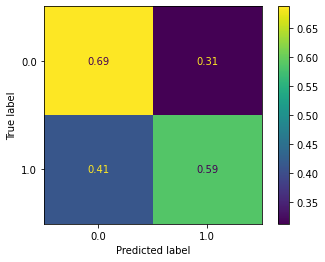

In [ ]:
plot_confusion_matrix(ensemble4, x_test, y_test[:,0], normalize='true')

E aqui as métricas conseguidas com o ensemble

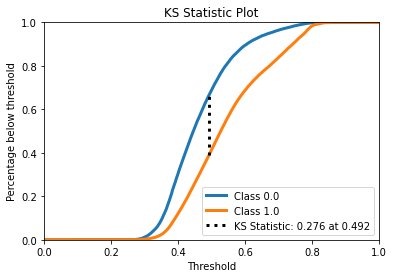


Accuracy:         0.6218
Recall:           0.5872
Precision:        0.7815
F1:               0.6706
AUROC:            0.6915
AUPR:             0.8046


In [ ]:
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_test[:,0], y_pred_ems4, y_pred_proba_ems4)
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)